In [1]:
import disklab
import numpy as np
import matplotlib.pyplot as plt
from disklab import DiskRadialModel
import disklab.natconst 
from disklab.diskradial import *
from disklab.natconst import *
from snippets import *
from scipy.optimize import curve_fit
import os

/home/adam/My_Environment/Projects/MSc_Courses/Accretion_Disks/DISKLAB-HE-main/disklab/disk2d.py:9: UserWarning: Importing diskvertical was successful, but 2D radiative diffusion not available, because diffusion.f90 has not been compiled to diffusion.so. All other methods of diskvertical.py remain available. For full functionality type make in disklab directory, which should produce the diffusion.so library using f2py.
  warnings.warn("Importing diskvertical was successful, but 2D radiative diffusion not available, because diffusion.f90 has not been compiled to diffusion.so. All other methods of diskvertical.py remain available. For full functionality type make in disklab directory, which should produce the diffusion.so library using f2py.")


In [2]:
# d.alpha     # Viscous alpha parameter (can be scalar or array)
# d.cs        # Isothermal sound speed [cm/s]
# d.flang     # Angle of incidence of stellar radiation (flaring angle)
# d.hp        # Pressure scale height of the disk [cm]
# d.lstar     # Luminosity of the star [erg/s]
# d.mass      # Mass of the disk [g]
# d.mstar     # Mass of the star [g]
# d.omk       # Array of the Kepler frequency [1/s]
# d.plsig     # Powerlaw index of gas surface density (only for information)
# d.r         # Array of the radial grid coordinate [cm]
# d.rhomid    # Array of the midplane gas density [g/cm^3]
# d.rstar     # Radius of the star [cm]
# d.Sc        # Schmidt number (only important for turbulent mixing)
# d.sigma     # Array of gas surface density [g/cm^2]
# d.sigmin    # Lower bound to gas surface density [g/cm^2]
# d.tmid      # Midplane disk temperature [K]
# d.tstar     # Stellar effective temperat
# d.mu        # Mean molecular mass [mp]
# d.omega     # Orbital angular frequency [1/s]
# d.vphi      # Azimuthal gas velocity [cm/s]
# d.dvphi     # Azimuthal gas velocity - Kepler velocity [cm/s]
# d.lphi      # Specific angular momentum [cm^2/s]
# d.dlnpdlnr  # Double-logarithmic derivative of the pressure

## Define Functions

In [3]:
# everything in CGS

def R_g(times,M):
    return times * (GG*M*MS)/cc**2
def L_acc(M,M_dot,R):
    return (GG*M*MS*M_dot)/R
def m_dot(R,x):                        # x = L_acc / L_edd
    return (4*np.pi*R*x*mp*cc)/st
def L_edd(M):
    return (4*np.pi*GG*mp*cc*M*MS)/st
def f_par(R,r):
    return (1-(R/r)**(1/2))**(1/4)

def Sigma2_analytic(M,x,r,nu):
    return (m_dot(R_g(6,M),x)*(1-(R_g(6,M)/r)**(1/2))/(3*np.pi*nu))

def Sigma_analytic(alpha,M,x,r):
    s_analytic= 5.2*alpha**(-4/5)*(m_dot(R_g(6,M),x)/1e16)**(7/10)*(M)**(1/4)*(r/1e10)**(-3/4)*f_par(R_g(6,M),r)**(14/5)
    return s_analytic

def Tmid_analytic(alpha,M,x,r):
    Tmid_analytic= 1.4e4*(alpha)**(-1/5)*(m_dot(R_g(6,M),x)/1e16)**(3/10)*(M)**(1/4)*(r/1e10)**(-3/4)*f_par(R_g(6,M),r)**(6/5)
    return Tmid_analytic

def nu_analytic(alpha,M,x,r):
    nu_analytic= 1.8e14*(alpha)**(4/5)*(m_dot(R_g(6,M),x)/1e16)**(3/10)*(M)**(-1/4)*(r/1e10)**(3/4)*f_par(R_g(6,M),r)**(6/5)
    return nu_analytic

def H_analytic(alpha,M,x,r):
    H_analytic= 1.7e8*(alpha)**(-1/10)*(m_dot(R_g(6,M),x)/1e16)**(3/20)*(M)**(-3/8)*(r/1e10)**(9/8)*f_par(R_g(6,M),r)**(3/5)
    return H_analytic

def opacity_model(disk,opacity,n_points,time_array,M,x):
    disk.meanopacitymodel=[opacity]
    disk.compute_mean_opacity()
    for itime in range(1, n_points + 1):
        disk.compute_nu()
        disk.sigma = disk.get_viscous_evolution_next_timestep(
            time_array[itime] - time_array[itime - 1],sigma_innerbc=d.sigma[1]/2,
            alphamodel=True, mdot_outerbc=m_dot(R_g(6,M),x))

        disk.compute_disktmid(vischeat=True, simple=True)
        disk.compute_cs_and_hp()
        disk.compute_rhomid_from_sigma()
        disk.compute_mean_opacity()
    return disk

def T_surf_analytic(M,R,x,r):
    const = (3*GG*M*MS*m_dot(R_g(R,M),x))/(8*ss*np.pi*r**3)
    return (const**(1/4)*f_par(R_g(R,M),r))

def T_surf_comp(D):
    return (D/(2*ss))**(1/4)

def luminosity(nu,M,x,Dr,i,r,D,case,R):
    ring_surf = 4*np.pi*r*Dr
    incl = np.cos(i*np.pi/180)
    if case=='analytic':
        planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_analytic(M,R,x,r)))-1)
    else:
        planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_comp(D)))-1)
    return (incl*ring_surf*planck_func)


## Main Code

In [4]:
Colorblind_custom=['#0072B2','#E69F00','#F0E442','#009E73','#000000','#56B4E9','#006400','#D55E00','#CC79A7']
current_path = os.getcwd() 
snippets_path = current_path+'/DISKLAB-HE-main/snippets'

## Computational Set 1

**Initial disk model evolved in time**

We examine thin disks and our goal is to solve the disk conservation equations as a function of radius and time. The first step is to verify that the disk convergences to a steady state in the absence of viscosity variations and compare the surface density profile with a simple analytical solution for a steady thin disk. For the analytical solution the kinematic viscosity, $\nu$, is assumed only function of radius, $r$, and follows the Shakura & Sunyaev parametrisation

\begin{equation}
\nu(r)=\alpha c_s H \; \frac{cm^{2}}{s} 
\label{eq:viscosity} \tag{1}
\end{equation}

where $0< \alpha < 1$, $c_s$ (sound speed) is determined by the midplane temperature, $T_{mid}$, via the isothermal ideal gas assumption, $c_s = \sqrt{\frac{k_B T_{mid}}{\mu m_p}} \; (\mu=2.3)$ and $H= \frac{c_s}{\Omega_K}$ (height scale). Furthermore, the opacity is described by Kramer's law
\begin{equation}
\kappa_R = 5 \times 10^{24} \rho T_c^{-\frac{7}{2}} \frac{cm^{2}}{g}
\label{eq:krammer_opacity} \tag{2}
\end{equation}

We assume an initaly massless thin disk around a $10 M_{\odot}$ black hole and a constant input mass accretion rate, $\dot{m}$, at the outermost radious of the disk. The Eddington limit implies a limit on the ${\it steady}$ accretion rate, $\dot{m}$, thus the latter is expressed as a fraction, $x=\frac{L_{acc}}{L_{Edd}} = 0.01$.

$$x = \frac{L_{acc}}{L_{Edd}}$$

$$x = \frac{\frac{GM\dot{m}}{R_{in}}}{\frac{4 \pi G Mm_pc}{\sigma_T}}$$

$$ \dot{m}(R_{in},x) = \frac{4 \pi R_{in} m_p c}{\sigma_T} x \label{eq:Edd_accretion_rate} \tag{3}$$

The inner disc radius, $R_{in}$, is determined by the the black hole mass. More specifically, we chose the innermost stable circular orbit (ISCO) as the inner boundry, because it corresponds to the smallest marginally stable circular orbit in which a test particle can stably orbit a massive object in general relativity. In our case we have a ${\it non-spinning}$ black hole, thus 

$$R_{ISCO} = 6R_g$$

$$R_{in} (M) = 6 \frac{GM}{c^2} \label{eq:inner_radius} \tag{4}$$


while $R_{out} = 600 R_g$. For simplicity, we chose to 'hide the physics' in the kinematic viscosity, $\nu$, which is set to be only function of radius, $r$. To do that we fix the Shakura & Sunyaev parameter $\alpha = 0.1$ and the sound speed is calculated via the condition $\frac{H}{R} =0.01$, thus we do not allow the code to compute a new viscosity in a self consistent manner. Finally, we try to exploit the fact that most parameters scale with the black hole mass, $M$. Hence, we implement it in our code structure and minimize the number of free parameters to which we assign values. To verify that the disk convergence to a steady state we evolve the disk varying the end of the simulation, $t_{end}$.

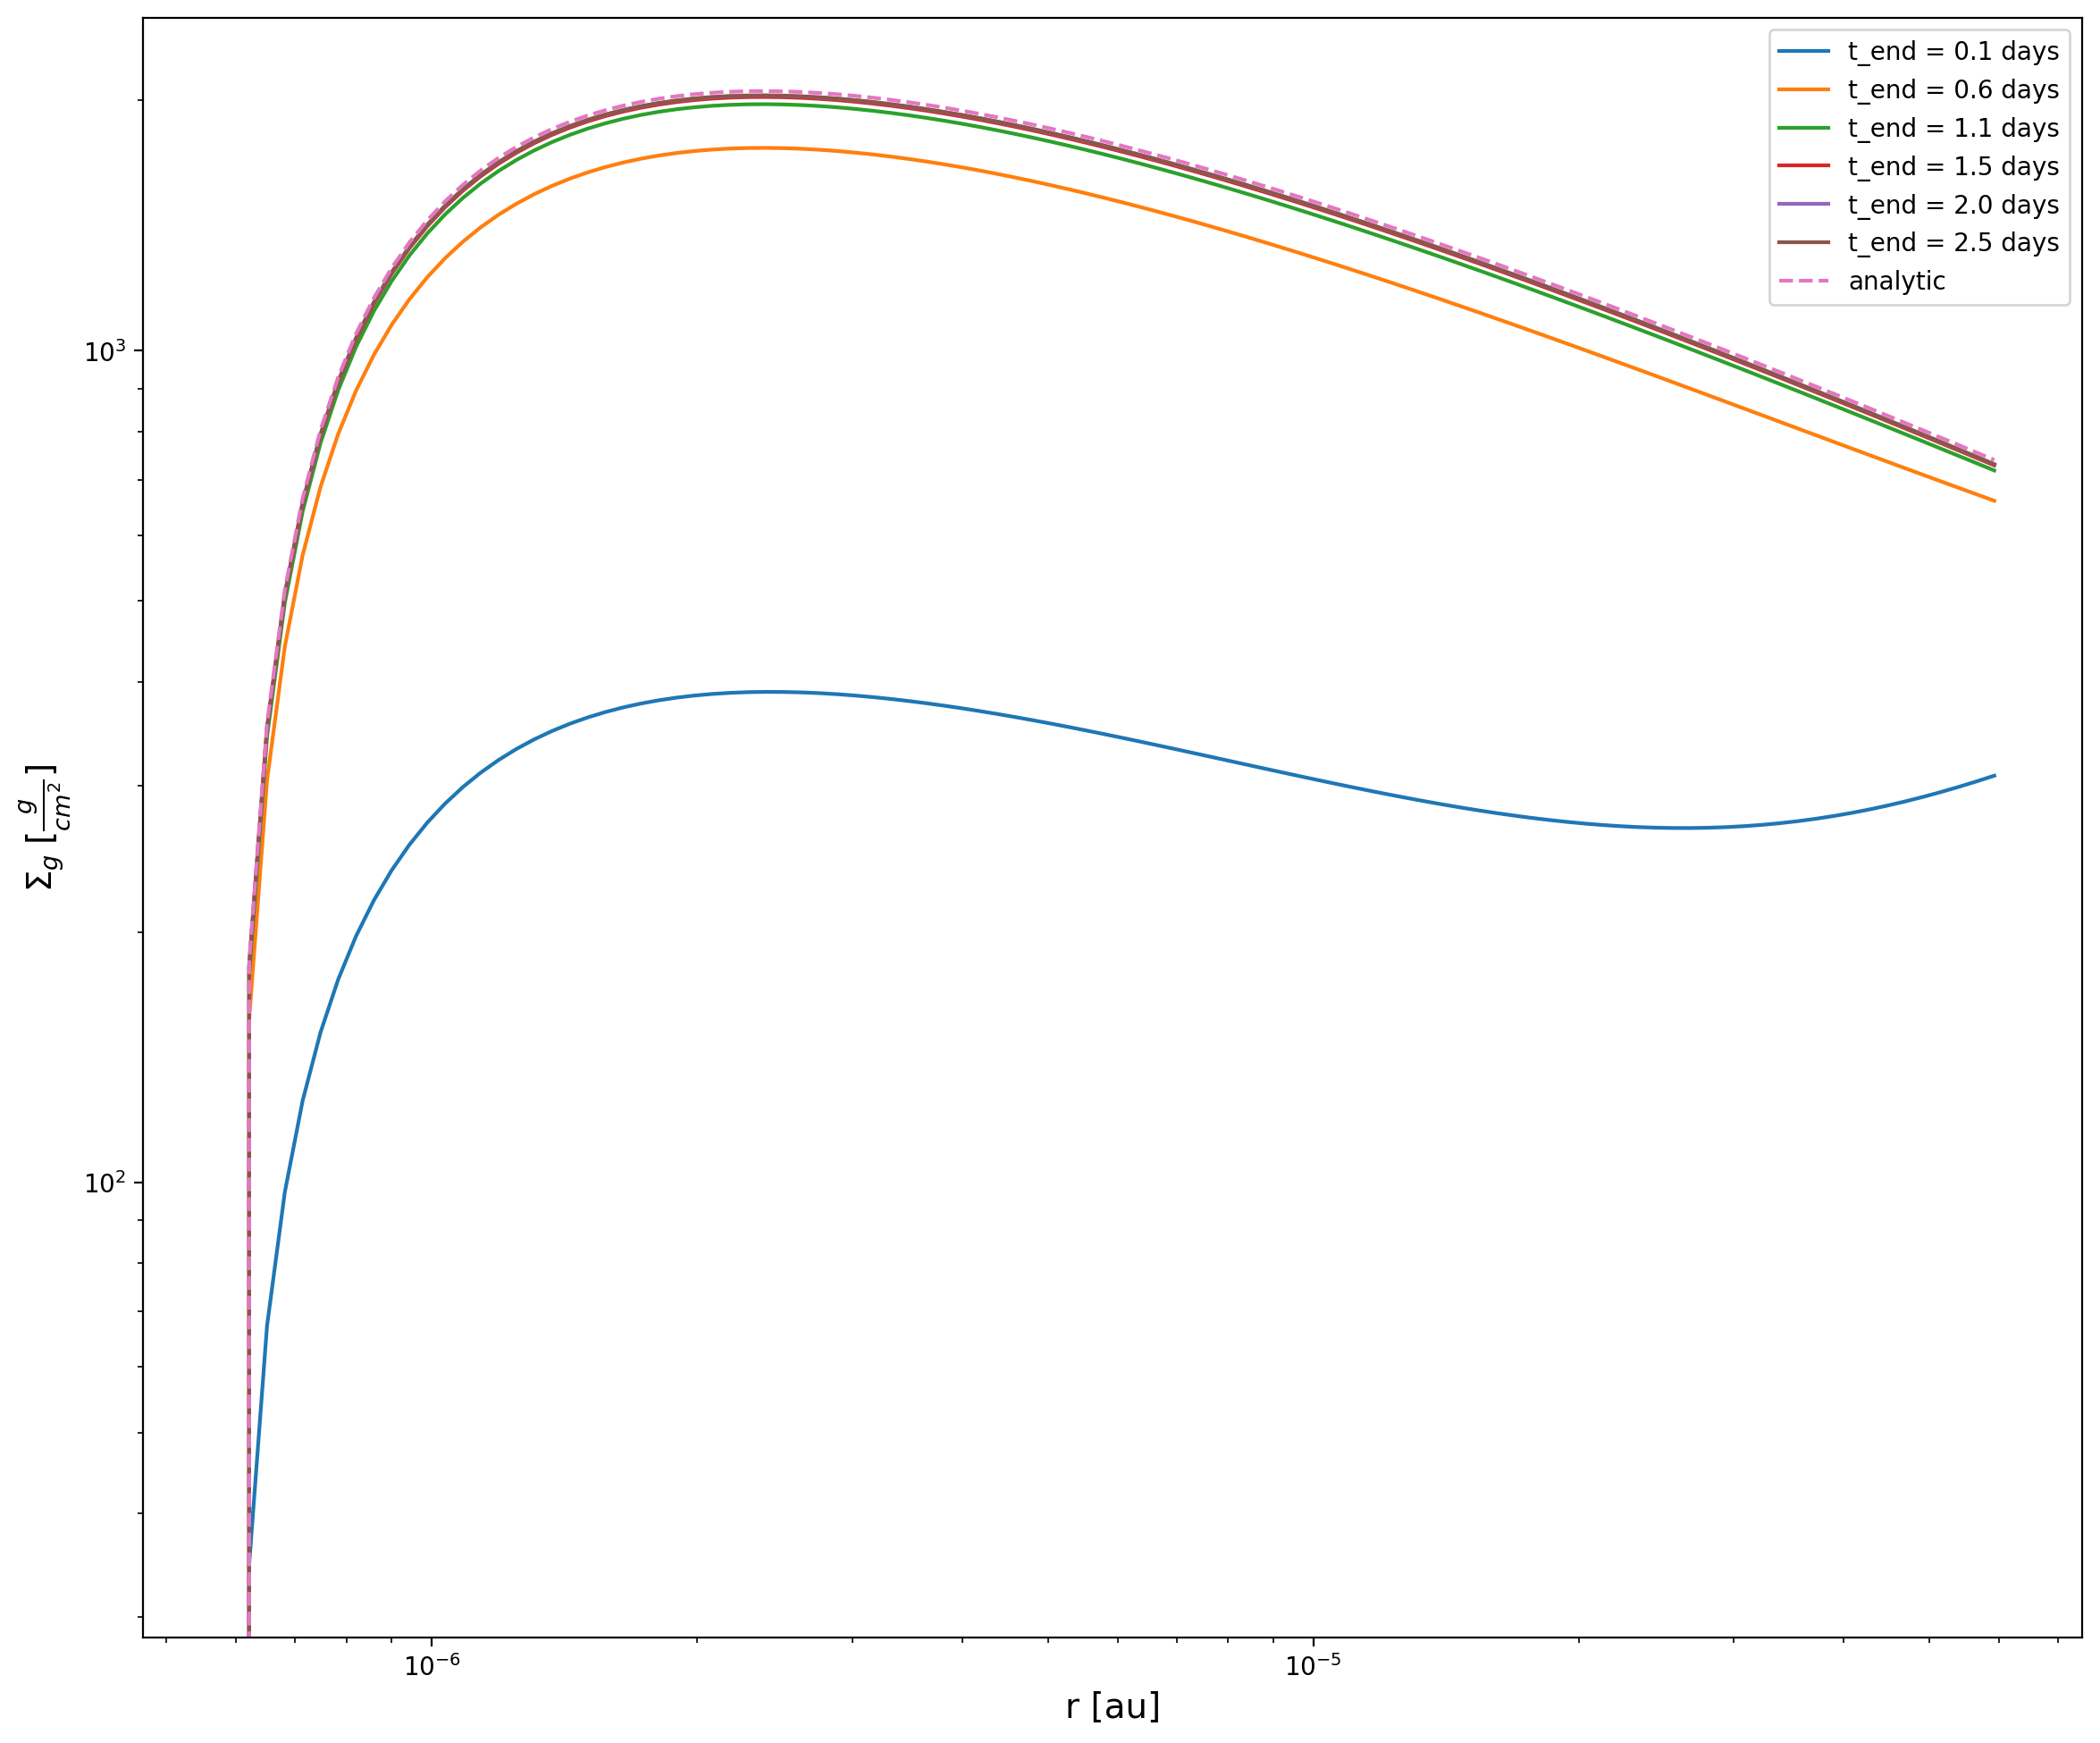

In [5]:
M = 10                                  # black hole mass
x = 0.01                                # fraction of M_dot Edd
alpha = 0.1

ntime = 300                            # number of points
t_start = 0.1
t_end = np.linspace(0.1,2.5,6)* day

plt.figure(figsize=(14,12),dpi=200)
for i,val in enumerate(t_end):
    d = DiskRadialModel(mstar=M*MS,lstar=0*LS,rin=R_g(6,M),rout=R_g(600,M), alpha=alpha)
    d.make_disk_from_m_pl(mdisk=0.0 * MS)
    time = t_start * (val / t_start)**(np.linspace(0., 1., ntime + 1))
    for itime in range(1, ntime + 1):
        d.compute_nu()
        d.sigma = d.get_viscous_evolution_next_timestep(time[itime] - time[itime - 1],sigma_innerbc=0.0,
                                                        alphamodel=False, mdot_outerbc=m_dot(R_g(6,M),x))
    plt.plot(d.r / au, d.sigma, label='t_end = {:.1f} days'.format(val/day))
plt.plot(d.r / au, Sigma2_analytic(M,x,d.r,d.nu), ls='dashed', label='analytic')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'r [au]', fontsize=14)
plt.ylabel(r'$\Sigma_g \; [\frac{g}{cm^2}]$', fontsize=14)
plt.show()

The above graph illustrates the surface density of the disk, $\Sigma(r)$, as a function of the distance, $r$, from the black hole at different time moments (snapshots of the disk evolution). The dashed line represents the analytic solution of the surface density profile for a steady thin disk

\begin{equation}
    \Sigma(r) = \frac{\dot{m}}{3 \pi \nu(r)}\Biggr(1-(\frac{R_{in}}{r})^{\frac{1}{2}}\Biggl)  \;\frac{cm^{2}}{s} 
\label{eq:viscosity} \tag{5}
\end{equation}

where again the physics are hidden in  $\nu$. 
The starting point of each line on the x-axis corresponds to the inner radius of the disk, $R_{in} = R_{ISCO}$ and initially the surface density is zero (which is expected for a massless disk), thus initially $\Sigma(R_{in})=0$. As the disk fills up at constant accretion rate, $\dot{m}$, we see that the mass is distributed to bigger distances, while at a time scale of $\sim 2 \; day$ the disc has already reached to a steady state.

This distribution of the mass occurs in viscous time-scale, $t_{visc}$, which corresponds to the time-scale for significant changes in surface density to propagate through the disk. We can try to estimate our result by doing a simple comparison with the viscous timescale, where using scale analysis we found that

$$ t_{visc} \sim \frac{R^2}{\nu} \label{eq:viscous_time_scale} \tag{6}$$
where $R=R_{out}$ the size of the disk and $\nu$ the kinematic viscosity.

As mentioned above the kinematic viscosity, $\nu$, is assumed only function of radius, $r$, and follows the Shakura & Sunyaev parametrisation (Eq.2). We can visualise that by ploting the kinematic viscosity, $\nu(r)$.

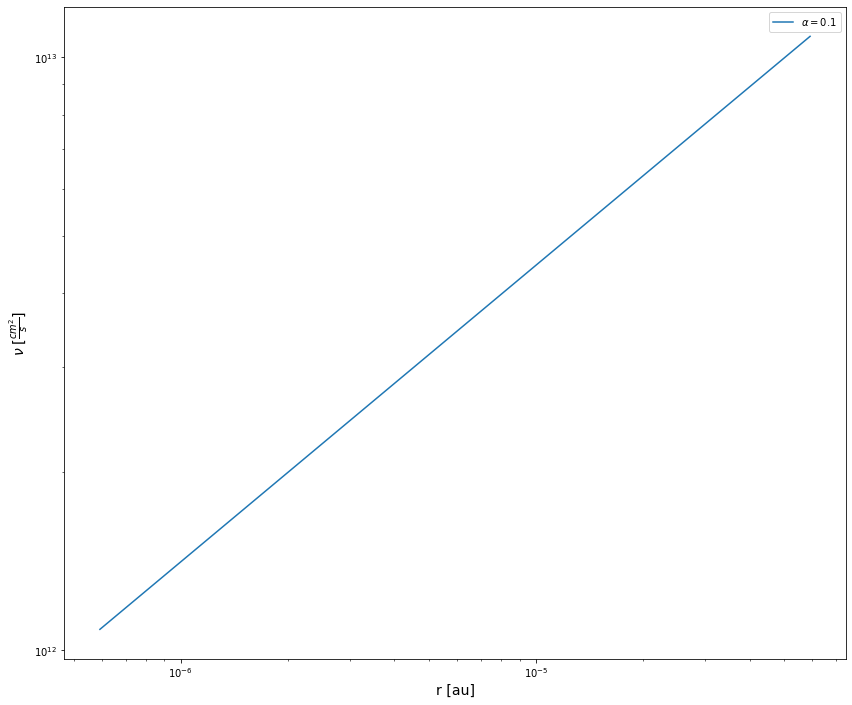

In [6]:
plt.figure(figsize=(14,12))
plt.plot(d.r/au,d.nu, label = r'$\alpha=0.1$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('r [au]', fontsize=14)
plt.ylabel(r'$\nu \; [\frac{cm^2}{s}]$', fontsize=14)
plt.show()

The size of the disk is $R_{out} \sim 600 R_g$ and $\nu$ can be estimated (order of magnitude) by (Eq.1): 

In [7]:
print('{:.1e} cm^2/s'.format((d.alpha*d.cs**2/d.omk).mean()))

4.3e+12 cm^2/s


From (Eq.6) :

In [8]:
t_visc = ((R_g(600,M))**2/((d.alpha*d.cs**2/d.omk).mean()))
print('{:.1f} days'.format(t_visc/day))

2.1 days


Our scale analysis estimation agrees with the our previous result.

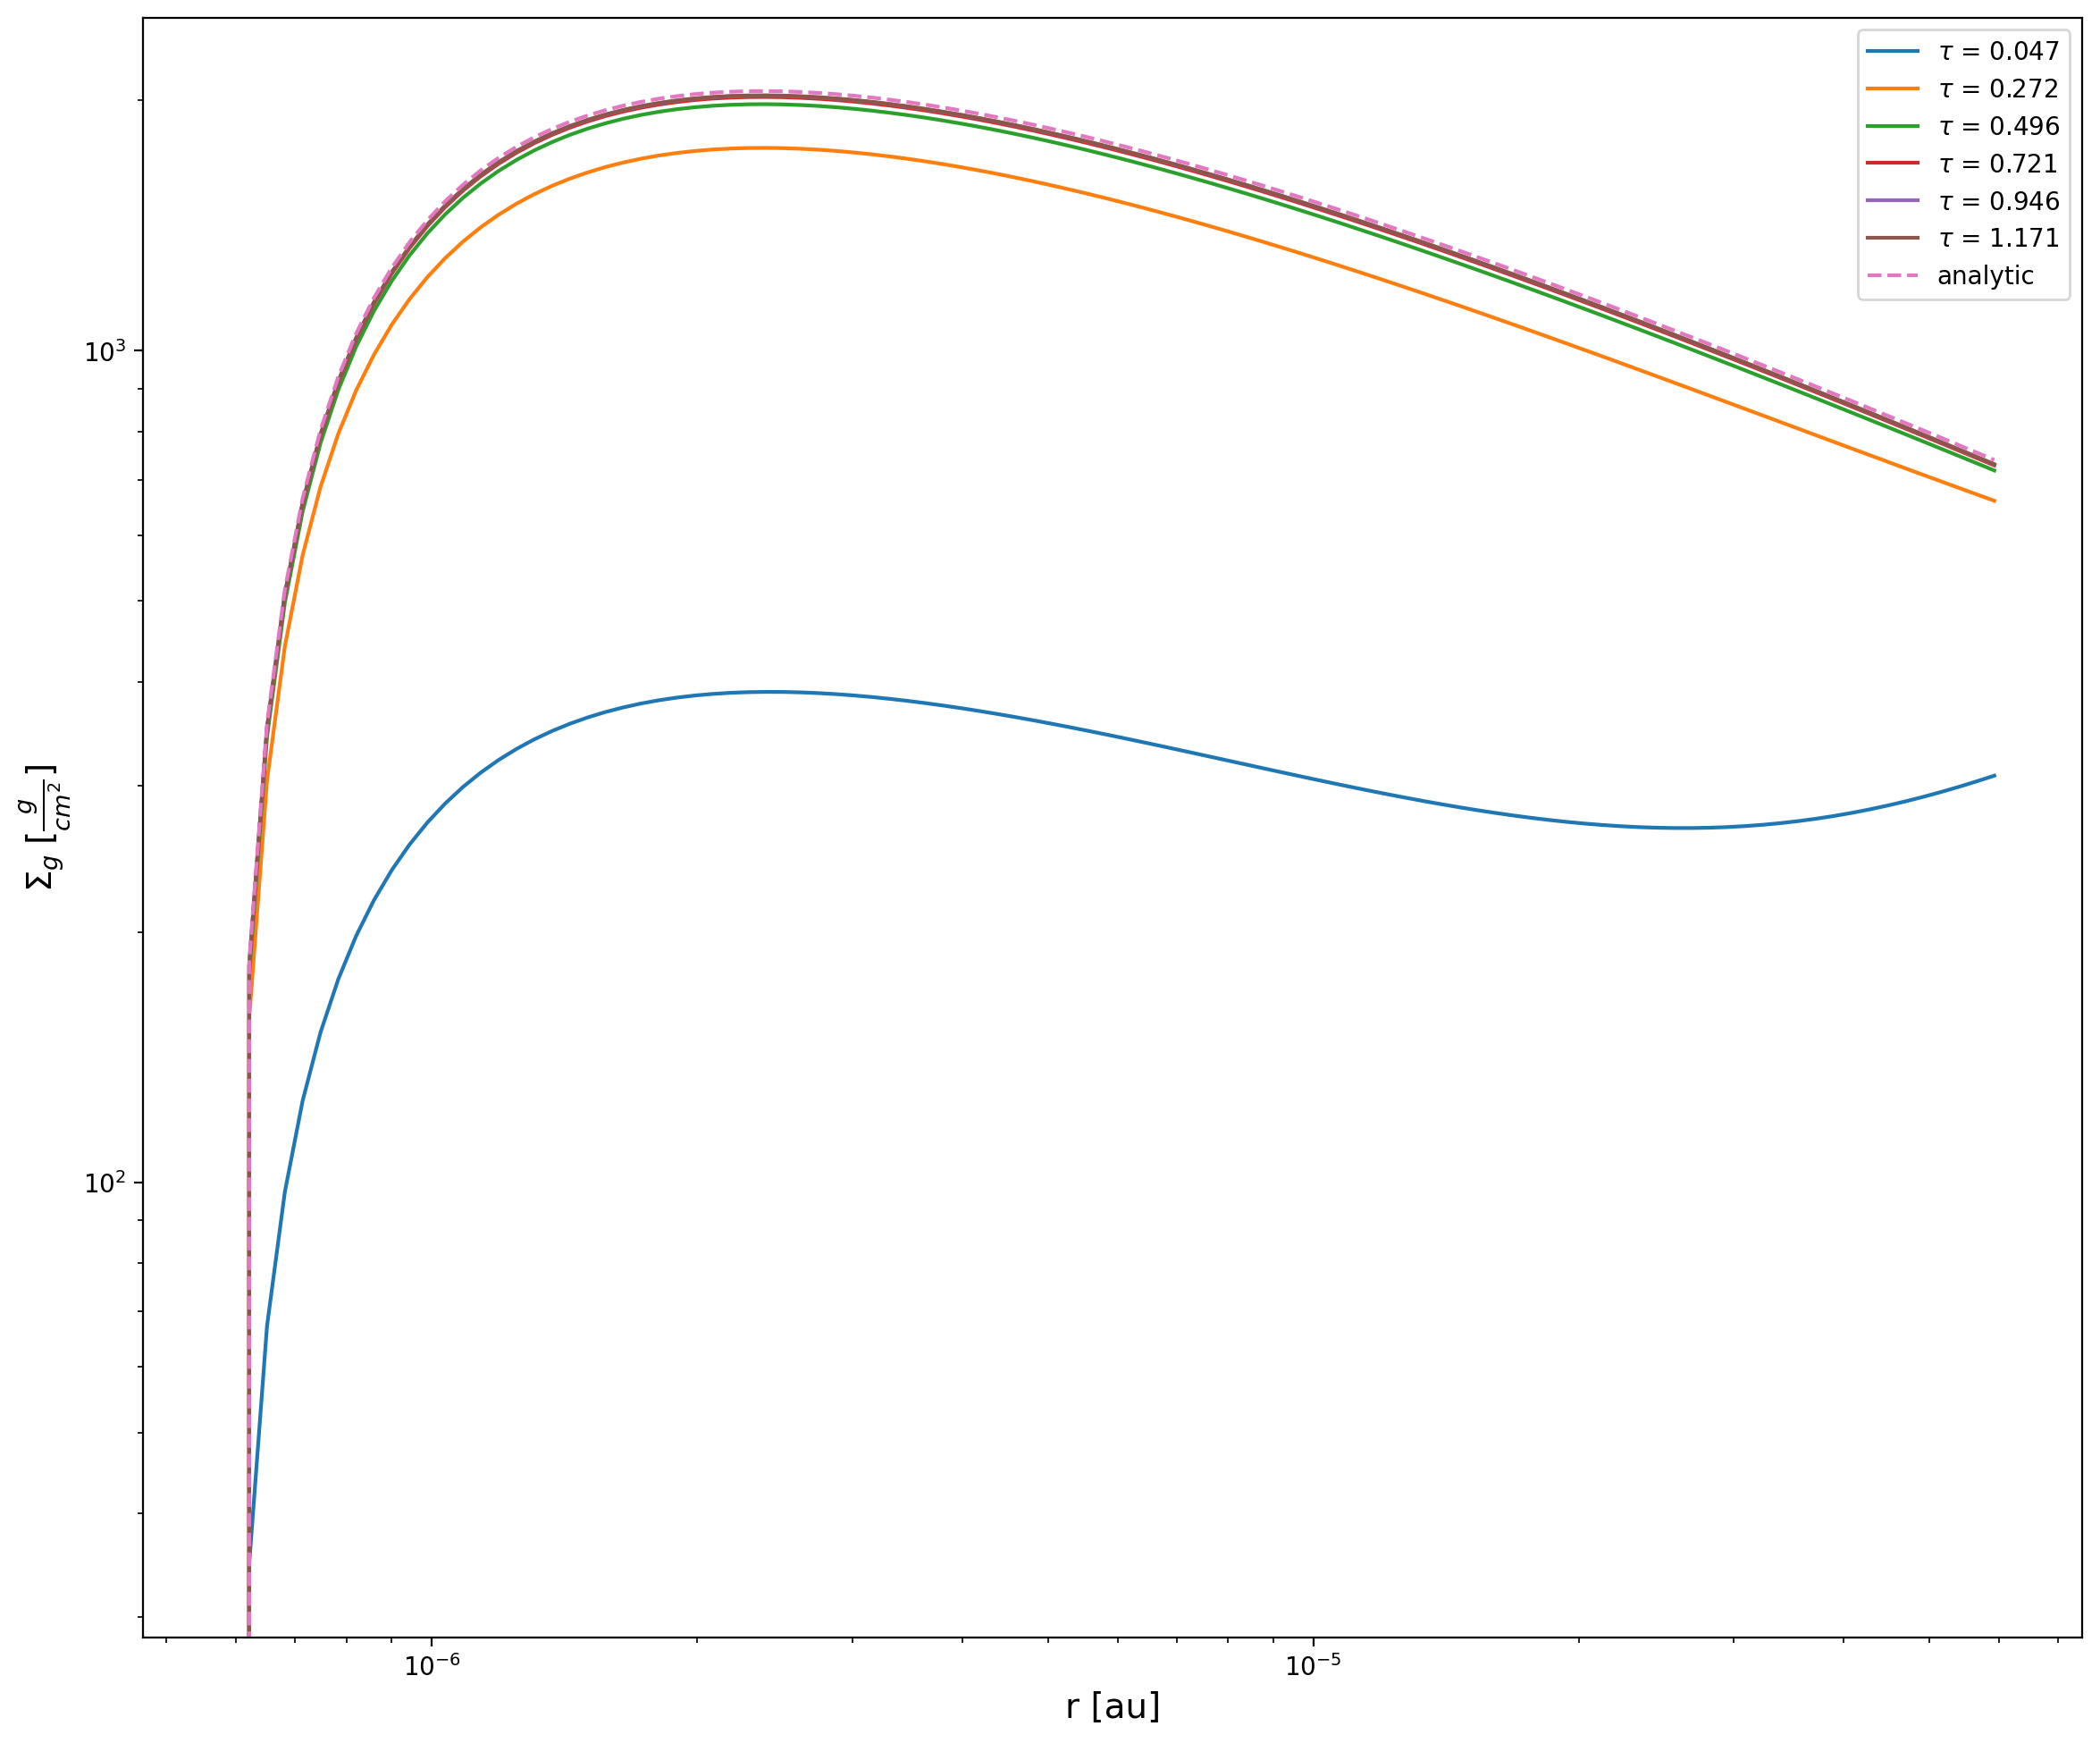

In [9]:
t_end = np.linspace(0.1,2.5,6)* day
plt.figure(figsize=(14,12),dpi=200)
for i,val in enumerate(t_end):
    d = DiskRadialModel(mstar=M*MS,lstar=0*LS,rin=R_g(6,M),rout=R_g(600,M), alpha=alpha)
    d.make_disk_from_m_pl(mdisk=0.0 * MS)
    time = t_start * (val / t_start)**(np.linspace(0., 1., ntime + 1))
    for itime in range(1, ntime + 1):
        d.compute_nu()
        d.sigma = d.get_viscous_evolution_next_timestep(time[itime] - time[itime - 1],sigma_innerbc=0.0,
                                                        alphamodel=False, mdot_outerbc=m_dot(R_g(6,M),x))
    plt.plot(d.r / au, d.sigma, label=r'$\tau$ = {:.3f}'.format(val/t_visc))
plt.plot(d.r / au, Sigma2_analytic(M,x,d.r,d.nu), ls='dashed', label='analytic')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('r [au]', fontsize=14)
plt.ylabel(r'$\Sigma_g \; [\frac{g}{cm^2}]$', fontsize=14)
plt.show()

The above plot is the same as before, but now we use the dimensionless variable 
$$\tau = \frac{t_{end}}{t_{visc}} \label{eq:viscous_norm_time_scale} \tag{7}$$ 
to show that the disk will convergence to a steady state after $\sim \tau=1$. From now on we use $t_{end}= 10\times t_{visc}$ exploiting the above analysis, while also securing that we have safe results. 

**Viscous heating and realistic opacities**

After verifying the viscous evolution, we also wanna solve for the heating and cooling of the disk which sets the mid-plane temperature $T_{mid}(r)$. In other words, we want to investigate the physics that remained hidden until now in the ${\nu}$ parameter. As mentioned before, $T_{mid}(r)$ determines the sound speed, $c_s(r)$ and consequently the scale height, $H(r)$ (see under Eq.(1)).  Here we model a thin disk around a black hole ($M = 10M_{\odot}$), thus we only include viscous heating and we can safely ignore everything about other heating mechanisms, such as irradiation. Disklab keeps track of the current viscous dissipation rate:

\begin{equation}\label{eq:dissipation_rate} \tag {8}
    D(r) = \frac{9}{4} \Sigma(r) \nu(r) \Omega_{K}^{2}(r)
\end{equation}


We assume that our disk is optically thick and that the disk medium is plane-parallel. As a result, the gas is in thermodynamic equilibrium when the disk reaches to a steady state, thus we can determine the mid-plane temperature $T_{mid}(r)$ by setting the balance between the cooling and the heating rate of the disc:

\begin{equation}\label{eq:thermal_equilibrium} \tag{9}
    \frac{4\sigma_{SB}}{3\tau(r)} T_{mid}^4(r) = \frac{9}{4} \Sigma(r) \nu(r) \Omega_{K}^{2}(r)
\end{equation}

However, the disk cools via irradiation and an optically thick disk radiates as a black body (photons escape from $\tau =1$). The `Eddington approximation` for the radiative energy transport between surface and mid-plane gives us:

\begin{equation}\label{eq:eddon_approx} \tag{10}
    T_{mid} = (\frac{3 \tau}{4})^{\frac{1}{4}} T_s 
\end{equation}

Eq. (9) and (10), indicate that $T_{mid}(r)$ will depend on $\tau$ , because the latter determines how much energy can escape from the disk surface as black body radiation. Disklab parametrizes the optical depth, $\tau$, by  using the `Rosseland mean opacity`, $\kappa_R$

\begin{equation}\label{eq:optical_depth} \tag{11}
    \tau = \Sigma \kappa_R(\rho, T_{mid}) 
\end{equation}

which is an avaraged opacity over the spectrum of the radiation. In reality, in different regions of the disk the $\rho$ and $T_{mid}$ will favor different mechanisms for photon interaction, which determine the opacity. For the sake of completeness, we mention that $\tau$ is also a function of frequency ($\tau_{\nu}$ and for different $\nu$, $\tau_{\nu}=1$ at different depths. In general, the radiative transfer is a very complex problem and a detailed analysis of it is out of the scope of this report.

From Eq.(9), (10) and the above analysis we expect an impact on the disk structure, $\Sigma (r)$ and $H(r)$. Here want to build realistic disks using different opacity laws and compare our solutions ($\Sigma,T_{mid},ν,H/R$) with the analytic ones. We examine three different opacity laws:

**`Kramer` opacity law for free-free absorption**

\begin{equation}\label{eq:krammer_law} \tag{12}
    \kappa_{ff} = 3.68 \times 10^{22} g_{ff}(1 − Z)(1 + X)\rho T_{mid}^{\frac{−7}{2}} \; \frac{cm^{2}}{g}
\end{equation}
where $g_{ff}=1, X=0.7$ and $Z=0.02$.

**`Electron Scattering` opacity law**

\begin{equation}\label{eq:electron_scatt} \tag{13}
    \kappa_{es} = 0.2 (1 + X) \; \frac{cm^{2}}{g}
\end{equation}
where $X=0.7$.

**`Free-Free absorption and Electron Scattering` combined opacity law**

\begin{equation}\label{eq:krammer_electron_scatt} \tag{14}
    \kappa_{ff} =  0.2 (1 + X)+  3.68 \times 10^{22} g_{ff}(1 − Z)(1 + X)\rho T_{mid}^{\frac{−7}{2}} \; \frac{cm^{2}}{g}
\end{equation}
where $g_{ff}=1, X=0.7$ and $Z=0.02$.

Eq.(9) indicates that $T_{mid}$ is depended on $\dot{m} \; (\Sigma \propto \dot{m})$ , thus a good point to start will be to vary the accretion rate, $\dot{m}$, at the outer radius of the disk so that we can see which opacity law dominates at different accretion rates. We can simply do that by varying the factor $x$, Eq.(3)

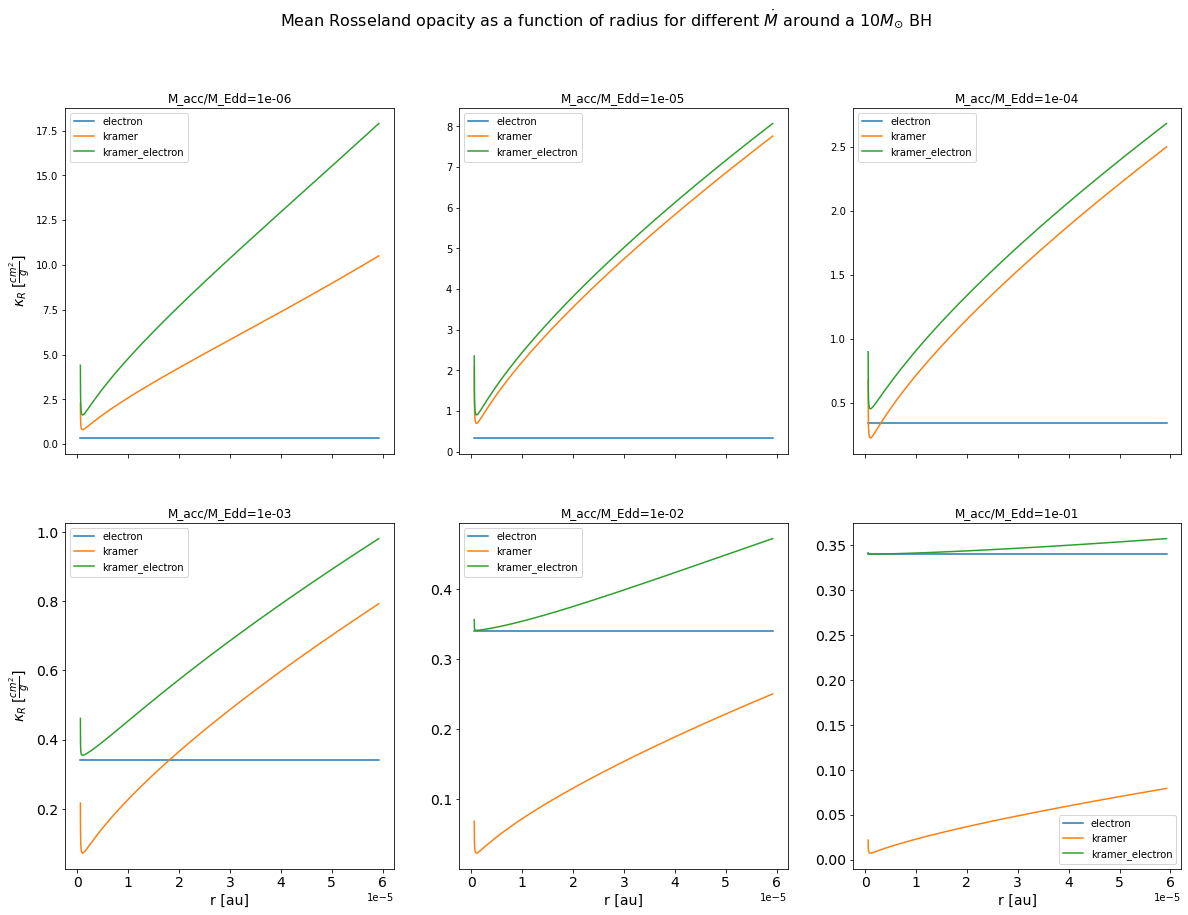

In [10]:
t_end = 10 * (R_g(600,M))**2/((d.nu).mean())

fig, ax = plt.subplots(2,3,figsize=(20,14),sharex=True)
fig.subplots_adjust(wspace=0.2,hspace=0.2)
d = DiskRadialModel(mstar=M*MS,lstar=0*LS,rin=R_g(6,M),rout=R_g(600,M), alpha=alpha, tbg=0.0)
d.make_disk_from_m_pl(mdisk=10e-10*MS)
time = t_start * (t_end / t_start)**(np.linspace(0., 1., ntime + 1))
for i,x in enumerate([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]):                  # fraction of M_dot Edd
    for opac in ['electron','kramer','kramer_electron']:
        if i ==0:
            opacity_model(d,opac,ntime,time,M,x)
            ax[0,0].plot(d.r / au, d.mean_opacity_rosseland, label=opac)
            ax[0,0].set_title('M_acc/M_Edd={:.0e}'.format(x))
            ax[0,0].legend()
        if i ==1:
            opacity_model(d,opac,ntime,time,M,x)
            ax[0,1].plot(d.r / au, d.mean_opacity_rosseland, label=opac)
            ax[0,1].set_title('M_acc/M_Edd={:.0e}'.format(x))
            ax[0,1].legend()
        if i ==2:
            opacity_model(d,opac,ntime,time,M,x)
            ax[0,2].plot(d.r / au, d.mean_opacity_rosseland, label=opac)
            ax[0,2].set_title('M_acc/M_Edd={:.0e}'.format(x))
            ax[0,2].legend()
        if i ==3:
            opacity_model(d,opac,ntime,time,M,x)
            ax[1,0].plot(d.r / au, d.mean_opacity_rosseland, label=opac)
            ax[1,0].set_title('M_acc/M_Edd={:.0e}'.format(x))
            ax[1,0].legend()
        if i ==4:
            opacity_model(d,opac,ntime,time,M,x)
            ax[1,1].plot(d.r / au, d.mean_opacity_rosseland, label=opac)
            ax[1,1].set_title('M_acc/M_Edd={:.0e}'.format(x))
            ax[1,1].legend()
        if i ==5:
            opacity_model(d,opac,ntime,time,M,x)
            ax[1,2].plot(d.r / au , d.mean_opacity_rosseland, label=opac)
            ax[1,2].set_title('M_acc/M_Edd={:.0e}'.format(x))
            ax[1,2].legend()
for i in range(2):
    if i == 0:
        ax[i,0].set_ylabel(r'$\kappa_{R} \; [\frac{cm^2}{g}]$', fontsize=14)
        ax[1,0].tick_params(axis='both', which='major', labelsize=14)
        ax[1,i].set_ylabel(r'$\kappa_{R} \; [\frac{cm^2}{g}]$', fontsize=14)
        ax[1,i].tick_params(axis='both', which='major', labelsize=14)        
    if i == 1:
        ax[i,0].set_xlabel('r [au]', fontsize=14)
        ax[i,0].tick_params(axis='both', which='major', labelsize=14)
        ax[i,1].set_xlabel('r [au]', fontsize=14)
        ax[i,1].tick_params(axis='both', which='major', labelsize=14)
        ax[i,2].set_xlabel('r [au]', fontsize=14)
        ax[i,2].tick_params(axis='both', which='major', labelsize=14)       
fig.suptitle(r'Mean Rosseland opacity as a function of radius for different $\dot{M}$ around a $10 M_{\odot}$ BH', fontsize=16)
plt.show()

First, we need to consider that each mechanism's efficiency will be dominant in different temperature regimes. Electron scattering is dominant at high temperatures where the gas is ionized and the number density of the free electrons is high, while free-free absorption is more important at lower temperatures where the gas is not fully ionized (but still there is a level of ionization). To interpret the above graph we can think that electron scattering opacity is constant for a given hydrogen abundance, Eq.(13). On the other hand, Kramer law is proportional to $\propto T_{mid}^{\frac{-7}{2}}$, Eq.(12). As mentioned above, by increasing the accretion rate, $\dot{m}$, at the outer radius of the disk we ''construct'' increasingly hotter disks, Eq.(9),and Kramer opacity becomes less and less important. For $x \gtrsim 0.01$ electron scattering is the dominant source of opacity.  Second, the disk mid-temperature is a function of radius  and for $r >> R_{in}$, $T_{mid} \propto r^{\frac{-3}{4}}$ (zero-th order approximation). Hence, at shorter radial distances the disk mid-temperature rises and electron scattering opacity is dominant over the Krammer opacity (for $x \gtrsim 0.01$). Conversely, as moving towards the outer parts of the disk, the temperature drops, and Krammer opacity contributes more to the average opacity than electron scattering opacity.E.g. in subfigure $x = 1e-3$ we see that at $r \sim 1.8e-5 AU$ the dominant opacity transitions from electron-scattering to free-free.

We now use $M = 10 ,x = 0.001, \alpha = 0.1$ and find the disk solutions for the three different opacity laws:

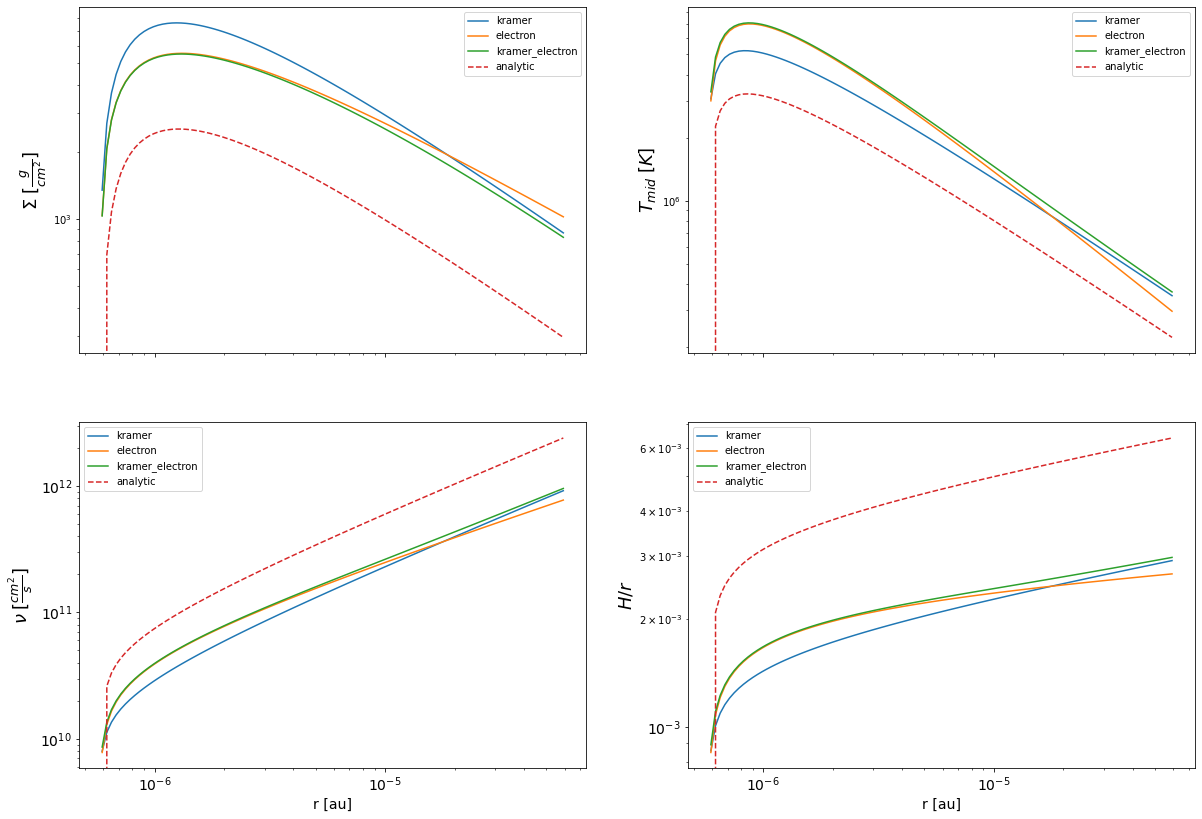

In [11]:
x=0.001
fig, ax = plt.subplots(2,2,figsize=(20,14),sharex=True)
fig.subplots_adjust(wspace=0.2)
d = DiskRadialModel(mstar=M*MS,lstar=0*LS,rin=R_g(6,M),rout=R_g(600,M), alpha=alpha, tbg=0.0)
d.make_disk_from_m_pl(mdisk=10e-10*MS)

time = t_start * (t_end / t_start)**(np.linspace(0., 1., ntime + 1))
for opac in ['kramer','electron','kramer_electron']:
    opacity_model(d,opac,ntime,time,M,x) 
    ax[0,0].plot(d.r / au, d.sigma, label=opac)
    ax[0,1].plot(d.r / au, d.tmid, label=opac)
    ax[1,0].plot(d.r / au, d.nu, label=opac)
    ax[1,1].plot(d.r / au, d.hp/d.r, label=opac)
    if opac == 'kramer_electron':
        ax[0,0].plot(d.r/au, Sigma_analytic(alpha,M,x,d.r), ls='dashed',label='analytic')
        ax[0,0].legend()
        ax[0,1].plot(d.r/au, Tmid_analytic(alpha,M,x,d.r), ls='dashed', label='analytic')
        ax[0,1].legend()
        ax[1,0].plot(d.r/au, nu_analytic(alpha,M,x,d.r), ls='dashed', label='analytic')
        ax[1,0].legend()
        ax[1,1].plot(d.r/au, H_analytic(alpha,M,x,d.r)/d.r, ls='dashed', label='analytic')
        ax[1,1].legend()
for i in range(2):
    if i == 1:
        ax[i,0].set_xlabel('r [au]', fontsize=14)
        ax[i,0].tick_params(axis='both', which='major', labelsize=14)
        ax[1,i].set_xlabel('r [au]', fontsize=14)
        ax[1,i].tick_params(axis='both', which='major', labelsize=14)
        ax[i,0].set_xscale('log')
        ax[i,0].set_yscale('log')
        ax[0,i].set_xscale('log')
        ax[0,i].set_yscale('log')
        ax[1,i].set_xscale('log')
        ax[1,i].set_yscale('log')
    else:
        ax[i,0].set_xscale('log')
        ax[i,0].set_yscale('log')
ax[0,0].set_ylabel(r'$\Sigma \; [ \frac{g}{cm^2}]$', fontsize=18)
ax[0,1].set_ylabel(r'$T_{mid} \; [K]$', fontsize=18)
ax[1,0].set_ylabel(r'$\nu \; [\frac{cm^2}{s}]$', fontsize=18)
ax[1,1].set_ylabel(r'$H/r$', fontsize=18)
plt.show()

The above graph presents the computational and the analytical solutions ($\Sigma,T_{mid},ν,H/R$). The analytical ones use the kramer law to calculate the opacity and we can see that they differ only on the propotionality constant, but the overall shape of the lines is the same. Furthermore, we can see how different opacity laws affect the lines. As mentioned before, we expect the electron scattering opacity (yellow line) to be dominant in the inner and hottest parts of the disk, while the kramer opacity (blue line) to dominate the outer and colder parts. Hence, we see that for small $r$ values the green line always overlaps with the yellow one, while as we move to bigger $r$ it follows the blue line. We can also see this transition where the green line start do diverge from the yellow line, which is abviously again at $r \sim 1.8e-5 AU$.

## Computational Set 2

## Thermal disk emission

We now want to produce a simple synthetic spectrum of our stationary disk, which is assumed that radiates locally as a blackbody. As a result, we need to calculate the surface temperature of the disk at different radii, $T_s (r)$. Disklab uses Eq.(9) and we use the combined `Kramer+electron scattering` opacity law to calculate the opacity, $\tau$. Analyticaly, $D(r)=\frac{3GM \dot{m}}{8 \pi r^3} (1-(\frac{R_{in}}{r})^{\frac{1}{2}})$ and thus

\begin{equation}\label{eq:thermal_equilibrium_anal} \tag{15}
    T_{s}(r) = \Biggl(\frac{3GM \dot{m}}{8 \pi \sigma_{SB} r^3} \Biggl(1-(\frac{R_{in}}{r})^{\frac{1}{2}}\Biggr)\Biggr)^{\frac{1}{4}}
\end{equation}

From Eq.(9) and (15) we determine the computed and analytic surface temperature profiles respectively. To better see the “multicolor blackbody” region of the disk, we set the $R_{out} = 5000 R_g$, because that region is more prominent for bigger disk size. 

/tmp/ipykernel_24115/2691846492.py:59: RuntimeWarning: divide by zero encountered in true_divide
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_analytic(M,R,x,r)))-1)
/tmp/ipykernel_24115/2691846492.py:61: RuntimeWarning: divide by zero encountered in true_divide
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_comp(D)))-1)
/tmp/ipykernel_24115/2691846492.py:59: RuntimeWarning: overflow encountered in exp
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_analytic(M,R,x,r)))-1)
/tmp/ipykernel_24115/2691846492.py:61: RuntimeWarning: overflow encountered in exp
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_comp(D)))-1)


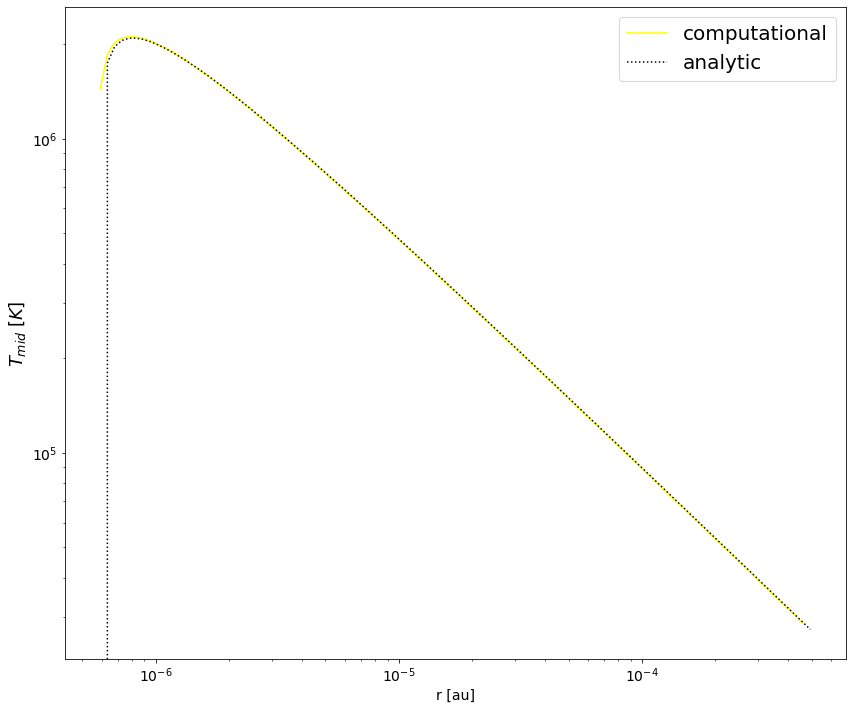

In [12]:
M = 10                                  # black hole mass
x = 0.01                                # fraction of M_dot Edd
alpha = 0.1                             # alpha parameter
incl = 0                                # inclination of the disk in degress
times_Rg_in = 6                         # inner radius : R_in = times_Rg_in * R_g
times_Rg_out = 5000                     # outer radius : R_out = times_Rg_out * R_g
ntime = 300                             # number of points
t_start = 0.1

frequency = np.logspace(0,20,1000)
d = DiskRadialModel(mstar=M*MS,lstar=0*LS,rin=R_g(times_Rg_in,M),rout=R_g(times_Rg_out,M), alpha=alpha, tbg=0.0)
d.make_disk_from_m_pl(mdisk=10e-10*MS)
d.compute_nu()

t_end = 10*(R_g(times_Rg_out,M))**2/((d.nu).mean()) # evolving the disk until 10t_visc            
time = t_start * (t_end / t_start)**(np.linspace(0., 1., ntime + 1))

opac = 'kramer_electron'                 # opacity  model we use
opacity_model(d,opac,ntime,time,M,x)     # calculate the opacity

r_mid = (d.r[1:]+d.r[:-1])/2             # the mean distance of each ring
Dr = np.diff(d.r)                        # the width of each ring
qvisc = d.qvisc[:-1]                     # the viscous dissipation rate for each r, but this r != r_mid thus some error

flux_anal = np.ones(1000)
flux_comp = np.ones(1000)

for i,j in enumerate(frequency):
    flux_anal[i] = np.sum(luminosity(j,M,x,Dr,incl,r_mid,d.qvisc,'analytic',times_Rg_in))   # provided by the analytical solution
    flux_comp[i] = np.sum(luminosity(j,M,x,Dr,incl,r_mid,qvisc,'computational',times_Rg_in)) # computed by the code
    
    
nu_L_nu_anal =frequency*flux_anal
nu_L_nu_comp =frequency*flux_comp
nu_L_nu_anal_max = nu_L_nu_anal[np.isfinite(flux_anal,where=True)].max()  # maximum emitted power provided by the analytical solution
nu_L_nu_comp_max = nu_L_nu_comp[np.isfinite(flux_anal,where=True)].max()  # maximum emitted power provided by the analytical solution

fig = plt.figure(figsize=(14,12))
plt.plot(d.r[:-1]/au,T_surf_comp(qvisc), label = 'computational', color= 'yellow')
plt.plot(d.r/au,T_surf_analytic(M,times_Rg_in,x,d.r), label = 'analytic', ls='dotted', color='black')
plt.xlabel('r [au]', fontsize=14)
plt.ylabel(r'$T_{mid} \; [K]$', fontsize=18)
plt.tick_params(labelsize=14)
plt.xscale('log')
plt.yscale('log')
plt.legend(prop={'size': 20})


We see that the analytical and the computational temperature profiles are in agreement. We now produce the synthetic spectra of our stationary disk and since it emits like a blackbody, the Planck spectrum is only function of temperature, $T_s (r)$. We use the above two temperature profiles and calculate the spectrum for each radius $(r)$, multiplying by the disk area (a ring) contributing to that radius, $4 \pi r dr$ (two sides), and summing the spectra for the other radii

\begin{equation}\label{sed} \tag{16}
    \nu L_{\nu} = \frac{4 \pi h \nu^4 cosi}{c^2 D^2}  \int_{R_{in}}^{R_{out}} \frac{r}{e^{h \nu/kT_s (r)}-1} \,dr
\end{equation}
where we assume the inclination is $i=0^{\circ}$ and the distance from the disk is not taken into account $D=1$.

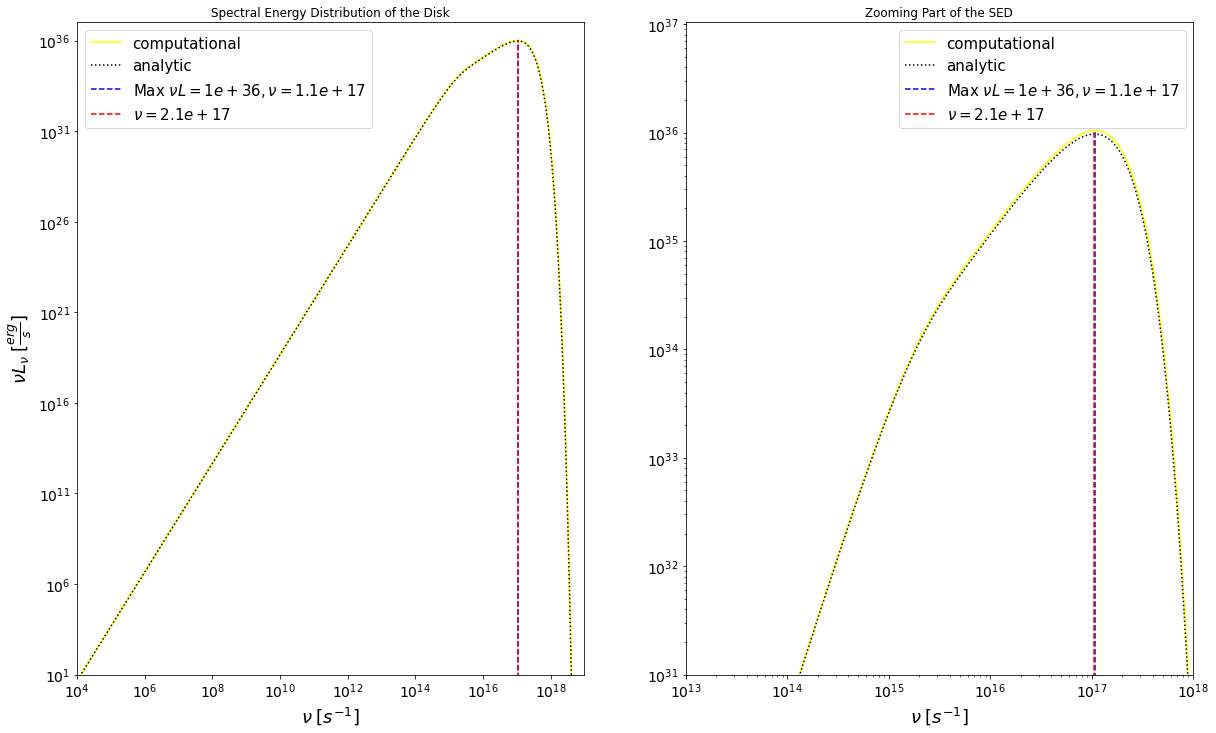

In [13]:
nu_max_L = frequency[np.where(nu_L_nu_anal==nu_L_nu_anal_max)[0][0]]
norm_freq = (frequency*hh)/(kk*T_surf_analytic(M,times_Rg_in,x,R_g(times_Rg_out,M)))
wien_law = lambda x: 2.821*kk*x/hh
T_anal = ((1.5*GG*M*MS*m_dot(R_g(times_Rg_in,M),x))/(8*np.pi*ss*R_g(times_Rg_in,M)**3))**0.25

fig, ax = plt.subplots(1,2,figsize=(20,12),sharex=False)
fig.subplots_adjust(wspace=0.2)
for i in range(2):
    ax[i].plot(frequency,nu_L_nu_comp, label='computational', color='yellow')
    ax[i].plot(frequency,nu_L_nu_anal, label='analytic', ls='dotted', color='black')
    ax[i].vlines(nu_max_L,color='blue',ymin=0,ymax=nu_L_nu_comp_max, ls = 'dashed', label=r'Max $\nu L={:.0e},\nu ={:.1e}$'.format(nu_L_nu_comp_max,nu_max_L))
    ax[i].vlines(wien_law(T_anal)/2,color='red',ymin=0,ymax=nu_L_nu_comp_max, ls = 'dashed', label=r'$\nu ={:.1e}$'.format(wien_law(T_anal)))
for i in range(2):
    if i == 0:
        ax[i].set_xlabel(r'$\nu \; [s^{-1}]$', fontsize=18)
        ax[i].set_ylabel(r'$\nu L_{\nu} \; [\frac{erg}{s}]$', fontsize=18)
        ax[i].tick_params(labelsize=14)
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].legend(prop={'size': 15})
        ax[i].set_ylim(1e1,10*nu_L_nu_comp_max)    # putting a limit of one order of magnitude > nu*L_nu_max
        ax[i].set_xlim(1e4,1e19)
        ax[i].set_title('Spectral Energy Distribution of the Disk')
    else:
        ax[i].set_xlabel(r'$\nu \; [s^{-1}]$', fontsize=18)
        ax[i].tick_params(labelsize=14)
        ax[i].legend(prop={'size': 15})
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].set_ylim(1e31,10*nu_L_nu_comp_max)
        ax[i].set_xlim(1e13,1e18)
        ax[i].set_title('Zooming Part of the SED')
plt.show()

We can clearly see that the analytical and the computational synthetic spectra overlap. We choose to plot $\nu L_{\nu}$ on the y-axis. thus the area under the line (the result of the integration) gives us directly the total emitted energy from the disk. Furthermore, the peak is directly associated with the effective temperature of disk via the  ${\it Wien \; law}$:

\begin{equation}\label{eq:wien_law} \tag{17}
    \nu_{max} = \frac{2.821k_B}{h} T_{eff}
\end{equation}
Here, the blue dashed line corresponds to the peak of the spectrum. We can also estimate the blackbody temperature for a thin and optically thick disk and using Eq. (17), try to verify the peak of the spectrum analyticaly. In order to do that we need to solve $\frac{d T_s}{dr} = 0$ where $T_s(r)$ is given by Eq.(15) and plug in our result back to Eq.(15), because we know that the maximum temperature dominates the spectrum. We actually did that calculation (Problem set 5) and found that the maximum temperature is given for $r=\frac{49}{36}R_{\star}$ (we solved that in the case where our compact object was a neutron star) and after plugging it in Eq.(15) we get

\begin{equation}\label{eq:blackbody_temp} \tag{18}
    T_{max} = 0.5 \times \Biggl(\frac{3GM \dot{m}}{8 \pi \sigma_{SB} R_{in}^3}\Biggr)^{1/4} 
\end{equation}

The red dashed line corresponds to the analytic peak of the spectrum, corresponding to the frequency calculated by Eq.(18) and Eq.(17). We can clearly see that our analytic solution agrees with the computed peak good enough.

In the lower frequency regime, $\sim \nu < 10^{14} s^{-1}$, the Planck function follows the Rayleigh-Jeans approximation

\begin{equation}\label{eq:rayleigh_jeans_approximation} \tag{19}
    B_{\nu} = \frac{2 \nu^2 k_B T}{c^2}
\end{equation}
This part of the spectrum corresponds to the ''coldest'' outer parts of the disk and we expect that in this frequency regime $\nu L_{\nu} \propto \nu^4$.

In the high frequency regime, $\sim \nu > 10^{17} s^{-1}$, the Planck function follows the Wien approximation
\begin{equation}\label{eq:wien_approximation} \tag{20}
    B_{\nu} = \frac{2 \nu^3}{c^2} e^{-h \nu/k_B T}
\end{equation}
This part of the spectrum corresponds to the ''hottest'' inner parts of the disk and we expect that in this frequency regime $\nu L_{\nu} \propto \nu^4 e^{-h \nu/k_B T}$.

Finally, at intermediate frequencies, $10^{14} < \nu < 10^{17} s^{-1}$, the spectrum represents a stretched-out blackbody and we expect $\sim \nu L_{\nu} \propto \nu^{4/3}$.

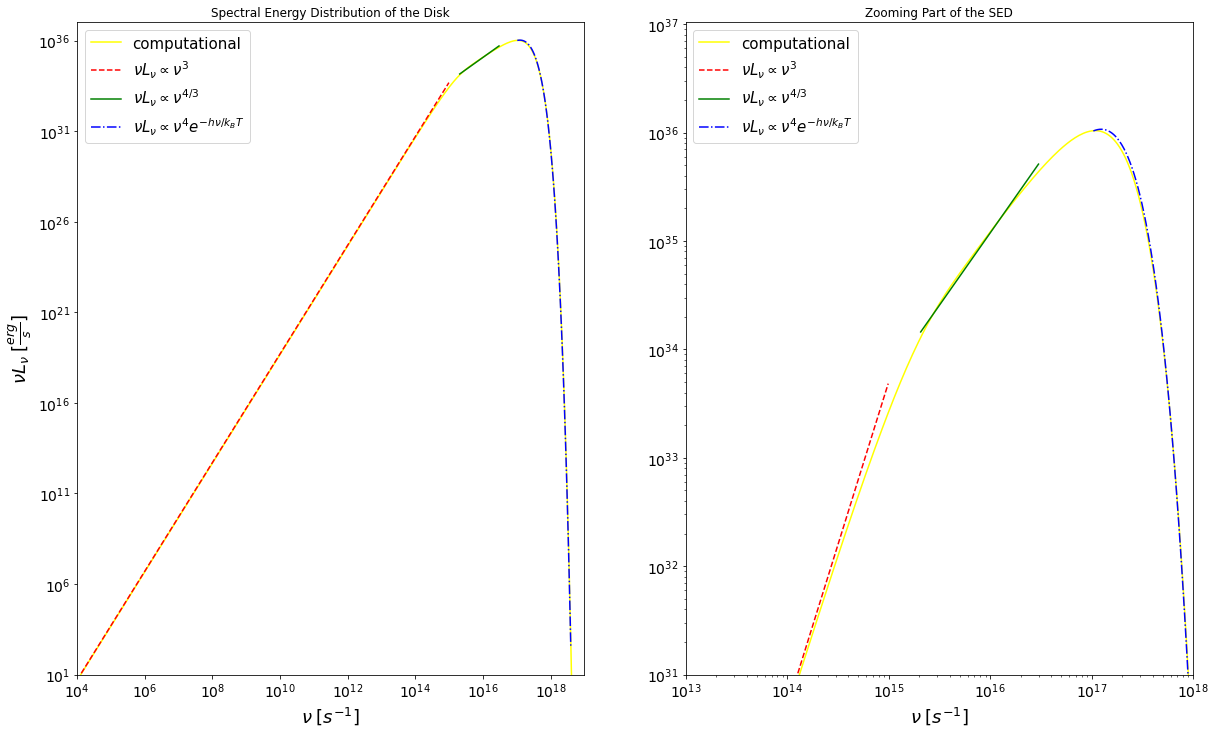

In [14]:
exp_func1 = lambda x,a,b: a*x**b
T_max = T_surf_comp(d.qvisc.max())
exp_func2 = lambda x: (2*hh*x**3/cc**2)/(np.exp((hh*x)/(kk*T_max))-1)

rayl_jeans = frequency[(frequency > 1e1) & (frequency < 1e15)]
multi_color = frequency[(frequency > 2e15) & (frequency < 3e16 )]
wien_tail = frequency[(frequency > 1e17 ) & (frequency < 4e18)]

fig, ax = plt.subplots(1,2,figsize=(20,12),sharex=False)
fig.subplots_adjust(wspace=0.2)
for i in range(2):
    ax[i].plot(frequency,nu_L_nu_comp, label='computational', color='yellow')
    ax[i].plot(rayl_jeans,exp_func1(rayl_jeans,5e-12,3),  ls='dashed', color='red', label=r'$\nu L_{\nu} \propto \nu^3$')
    ax[i].plot(multi_color,exp_func1(multi_color,5.5e13,4/3),  ls='solid', color='green', label=r'$\nu L_{\nu} \propto \nu^{4/3}$')
    ax[i].plot(wien_tail,6e32*exp_func2(wien_tail),  ls='dashdot', color='blue', label=r'$\nu L_{\nu} \propto \nu^4e^{-h \nu/k_B T}$')
for i in range(2):
    if i == 0:
        ax[i].set_xlabel(r'$\nu \; [s^{-1}]$', fontsize=18)
        ax[i].set_ylabel(r'$\nu L_{\nu} \; [\frac{erg}{s}]$', fontsize=18)
        ax[i].tick_params(labelsize=14)
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].legend(prop={'size': 15})
        ax[i].set_ylim(1e1,10*nu_L_nu_comp_max)    # putting a limit of one order of magnitude > nu*L_nu_max
        ax[i].set_xlim(1e4,1e19)
        ax[i].set_title('Spectral Energy Distribution of the Disk')
    else:
        ax[i].set_xlabel(r'$\nu \; [s^{-1}]$', fontsize=18)
        ax[i].tick_params(labelsize=14)
        ax[i].legend(prop={'size': 15})
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].set_ylim(1e31,10*nu_L_nu_comp_max)
        ax[i].set_xlim(1e13,1e18)
        ax[i].set_title('Zooming Part of the SED')
plt.show()

We can clearly see that the SED confirms what we expect not only for the low- and high- frequency regions,
but also for the multicolor blackbody region.

Finally, we want to examine how the spectrum changes by varying five parameters:

- The length of the inner radius, $R_{in}$
- The inclination of the disk, $i$
- The length of the outer radius, $R_{out}$
- Accretion rate at the outer edge of the disk, $\dot{m}$
- The black hole mass, $M$

We choose to plot the SED for the analytical and the computational temperature profiles, but our analysis is focused on the the latter case.

**Varying the inner radius**

/tmp/ipykernel_24115/2691846492.py:59: RuntimeWarning: divide by zero encountered in true_divide
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_analytic(M,R,x,r)))-1)
/tmp/ipykernel_24115/2691846492.py:61: RuntimeWarning: divide by zero encountered in true_divide
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_comp(D)))-1)
/tmp/ipykernel_24115/2691846492.py:59: RuntimeWarning: overflow encountered in exp
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_analytic(M,R,x,r)))-1)
/tmp/ipykernel_24115/2691846492.py:61: RuntimeWarning: overflow encountered in exp
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_comp(D)))-1)
/tmp/ipykernel_24115/2691846492.py:59: RuntimeWarning: divide by zero encountered in true_divide
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_analytic(M,R,x,r)))-1)
/tmp/ipykernel_24115/2691846492.py:61: RuntimeWarning: divide by zero encountered in true_divide
  planck_func = (2*hh*nu**3/cc**2)/(np.ex

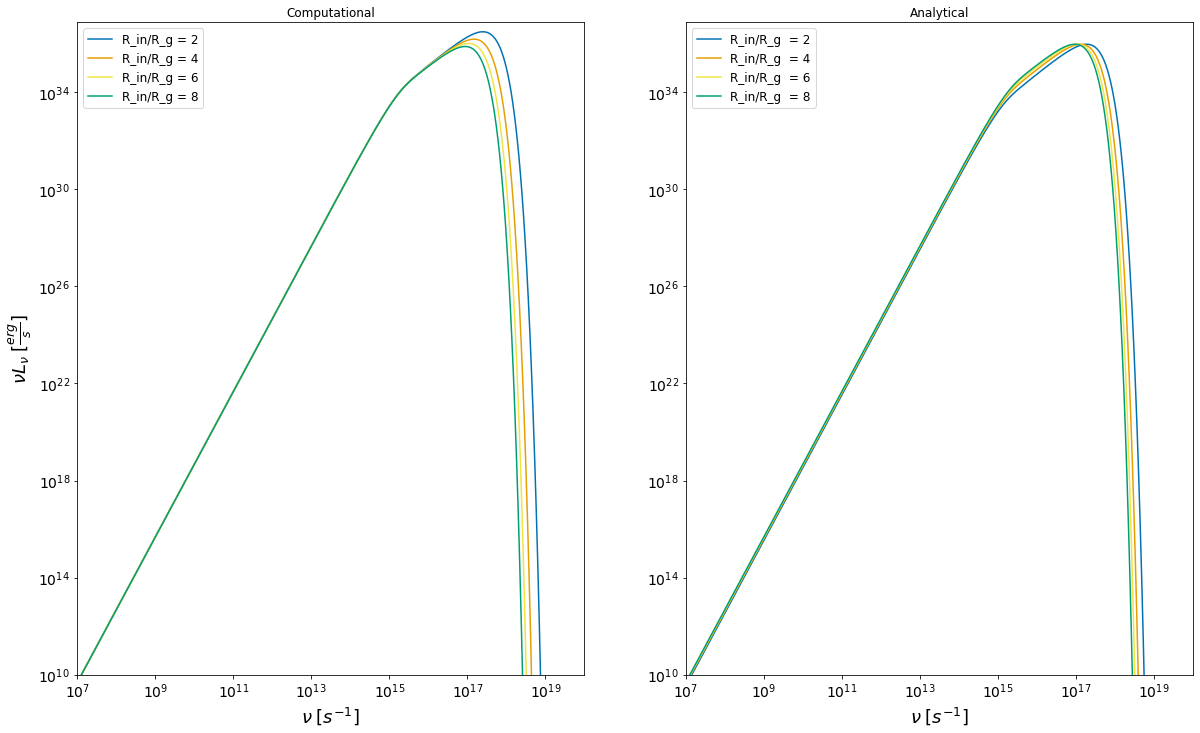

In [15]:
M = 10                                  # black hole mass
x = 0.01                                # fraction of M_dot Edd
alpha = 0.1                             # alpha parameter
incl = 0                                # inclination of the disk in degress
times_Rg_out = 5000                     # outer radius : R_out = times_Rg_out * R_g
ntime = 300                             # number of points
t_start = 0.1
opac = 'kramer_electron'                 # opacity  model we use
frequency = np.logspace(0,20,1000)
times_Rg_in_array = [2,4,6,8]              # inner radius : R_in = times_Rg_in * R_g

fig, ax = plt.subplots(1,2,figsize=(20,12))
fig.subplots_adjust(wspace=0.2)

for times_Rg_in,color in zip(times_Rg_in_array,Colorblind_custom):
    d = DiskRadialModel(mstar=M*MS,lstar=0*LS,rin=R_g(times_Rg_in,M),rout=R_g(times_Rg_out,M), alpha=alpha, tbg=0.0)
    d.make_disk_from_m_pl(mdisk=10e-10*MS)
    d.compute_nu()

    t_end = 10*(R_g(times_Rg_out,M))**2/((d.nu).mean()) # evolving the disk until 10t_visc            
    time = t_start * (t_end / t_start)**(np.linspace(0., 1., ntime + 1))

    opacity_model(d,opac,ntime,time,M,x)     # calculate the opacity

    r_mid = (d.r[1:]+d.r[:-1])/2             # the mean distance of each ring
    Dr = np.diff(d.r)                        # the width of each ring
    qvisc = d.qvisc[:-1]                     # the viscous dissipation rate for each r, but this r != r_mid thus some error

    flux_anal = np.ones(1000)
    flux_comp = np.ones(1000)

    for i,j in enumerate(frequency):
        flux_anal[i] = np.sum(luminosity(j,M,x,Dr,incl,r_mid,d.qvisc,'analytic',times_Rg_in))   # provided by the analytical solution
        flux_comp[i] = np.sum(luminosity(j,M,x,Dr,incl,r_mid,qvisc,'computational',times_Rg_in)) # computed by the code


    nu_L_nu_anal =frequency*flux_anal
    nu_L_nu_comp =frequency*flux_comp
    nu_L_nu_anal_max = nu_L_nu_anal[np.isfinite(flux_anal,where=True)].max()  # maximum emitted power provided by the analytical solution
    nu_L_nu_comp_max = nu_L_nu_comp[np.isfinite(flux_comp,where=True)].max()  # maximum emitted power provided by the analytical solution

    ax[0].plot(frequency,nu_L_nu_comp, label= 'R_in/R_g = {:.0f}'.format(times_Rg_in), color=color)
    ax[1].plot(frequency,nu_L_nu_anal, label= 'R_in/R_g  = {:.0f}'.format(times_Rg_in), color=color)
    for i in range(2):
        if i == 0:
            #axis
            ax[i].set_ylabel(r'$\nu L_{\nu} \; [\frac{erg}{s}]$', fontsize=18)
            ax[i].tick_params(labelsize=14)
            ax[i].set_xlabel(r'$\nu \; [s^{-1}]$', fontsize=18)
            ax[i].tick_params(labelsize=14)
            ax[i].set_title('Computational')
            ax[i].legend(prop={'size': 12})
            
            # scaling axis
            ax[i].set_xlim(1e7,1e20)
            ax[i].set_yscale('log')
            ax[i].set_xscale('log')
            ax[i].set_ylim(1e10,10*nu_L_nu_comp_max)
        else:
            #axis
            ax[i].set_xlabel(r'$\nu \; [s^{-1}]$', fontsize=18)
            ax[i].tick_params(labelsize=14)
            ax[i].set_title('Analytical')
            ax[i].legend(prop={'size': 12})
            
            # scaling axis
            ax[i].set_xlim(1e7,1e20)
            ax[i].set_yscale('log')
            ax[i].set_xscale('log')
            ax[i].set_ylim(1e10,10*nu_L_nu_comp_max)
plt.show()

The above graph indicates two important things. First, as we chose smaller inner radii for our model disc the total emitted energy becomes bigger. Second, the disk becomes hotter and we see that because the peak of the SED moves to higher frequencies (Eq.(17)). This is expected, because we can simply think this in terms of the Virial Theorem 
\begin{equation}\label{virial_theorem} \tag{21}
    E_{int}= -\frac{1}{2} E_{gr}
\end{equation}
where $E_{int} \sim \frac{3}{2 \mu m_u}TM$ and $E_{gr} \sim -\alpha \frac{GM^2}{R}$

Where, by decreasing $R_{in}$ we allow the gas to accrete at closer distance onto the Black hole (deeper in the potential well), thus more potential energy is released. Half of it escapes as luminosity and the other half is given as internal energy heating the disk. 

**Varying the Inclination of the Disk**

/tmp/ipykernel_24115/2691846492.py:59: RuntimeWarning: divide by zero encountered in true_divide
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_analytic(M,R,x,r)))-1)
/tmp/ipykernel_24115/2691846492.py:61: RuntimeWarning: divide by zero encountered in true_divide
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_comp(D)))-1)
/tmp/ipykernel_24115/2691846492.py:59: RuntimeWarning: overflow encountered in exp
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_analytic(M,R,x,r)))-1)
/tmp/ipykernel_24115/2691846492.py:61: RuntimeWarning: overflow encountered in exp
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_comp(D)))-1)
/tmp/ipykernel_24115/2691846492.py:59: RuntimeWarning: divide by zero encountered in true_divide
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_analytic(M,R,x,r)))-1)
/tmp/ipykernel_24115/2691846492.py:61: RuntimeWarning: divide by zero encountered in true_divide
  planck_func = (2*hh*nu**3/cc**2)/(np.ex

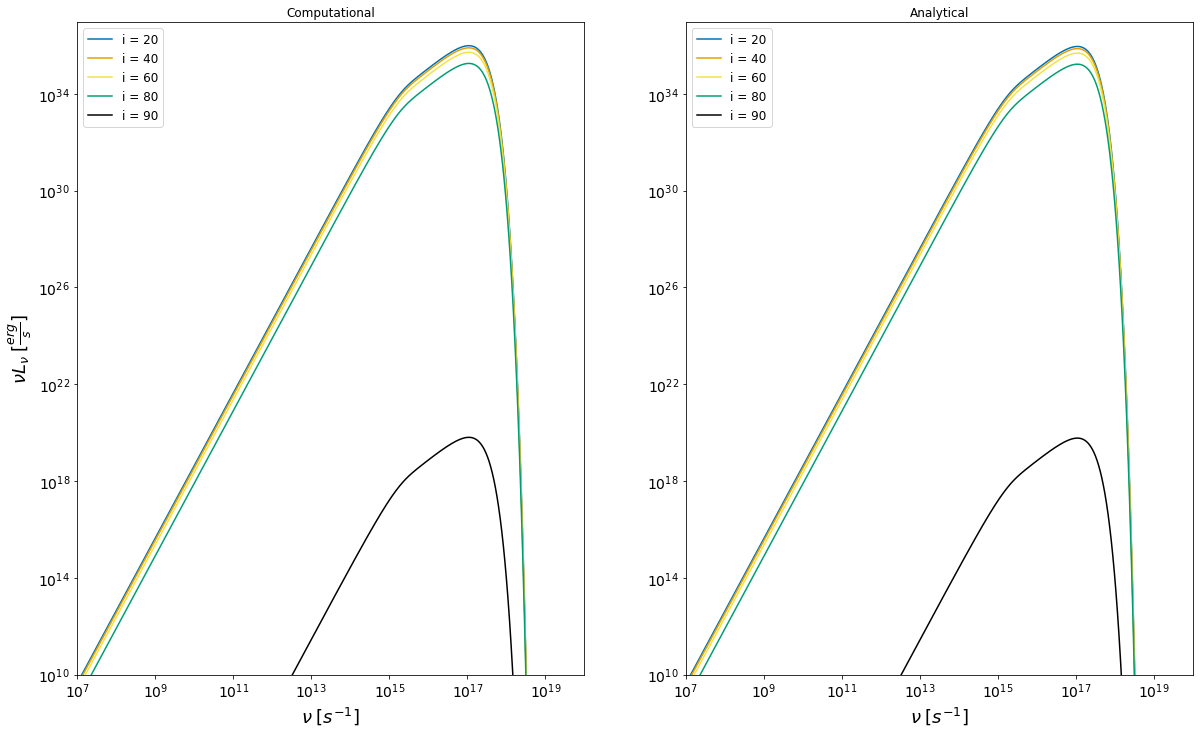

In [16]:
M = 10                                  # black hole mass
x = 0.01                                # fraction of M_dot Edd
alpha = 0.1                             # alpha parameter                               
times_Rg_in = 6                         # inner radius : R_in = times_Rg_in * R_g
times_Rg_out = 5000                     # outer radius : R_out = times_Rg_out * R_g
ntime = 300                             # number of points
t_start = 0.1
opac = 'kramer_electron'                 # opacity  model we use
frequency = np.logspace(0,20,1000)
inc_array = [20.0,40.0,60.0,80.0,90.0]              # inclination of the disk in degress

fig, ax = plt.subplots(1,2,figsize=(20,12))
fig.subplots_adjust(wspace=0.2)

for incl,color in zip(inc_array,Colorblind_custom):
    d = DiskRadialModel(mstar=M*MS,lstar=0*LS,rin=R_g(times_Rg_in,M),rout=R_g(times_Rg_out,M), alpha=alpha, tbg=0.0)
    d.make_disk_from_m_pl(mdisk=10e-10*MS)
    d.compute_nu()

    t_end = 10*(R_g(times_Rg_out,M))**2/((d.nu).mean()) # evolving the disk until 10t_visc            
    time = t_start * (t_end / t_start)**(np.linspace(0., 1., ntime + 1))

    opacity_model(d,opac,ntime,time,M,x)     # calculate the opacity

    r_mid = (d.r[1:]+d.r[:-1])/2             # the mean distance of each ring
    Dr = np.diff(d.r)                        # the width of each ring
    qvisc = d.qvisc[:-1]                     # the viscous dissipation rate for each r, but this r != r_mid thus some error

    flux_anal = np.ones(1000)
    flux_comp = np.ones(1000)

    for i,j in enumerate(frequency):
        flux_anal[i] = np.sum(luminosity(j,M,x,Dr,incl,r_mid,d.qvisc,'analytic',times_Rg_in))   # provided by the analytical solution
        flux_comp[i] = np.sum(luminosity(j,M,x,Dr,incl,r_mid,qvisc,'computational',times_Rg_in)) # computed by the code

    
    nu_L_nu_anal =frequency*flux_anal
    nu_L_nu_comp =frequency*flux_comp
    nu_L_nu_anal_max = nu_L_nu_anal[np.isfinite(flux_anal,where=True)].max()  # maximum emitted power provided by the analytical solution
    nu_L_nu_comp_max = nu_L_nu_comp[np.isfinite(flux_comp,where=True)].max()  # maximum emitted power provided by the analytical solution
    if incl == inc_array[0]:
        ylim = nu_L_nu_anal_max
    
    nu_max_L = frequency[np.where(nu_L_nu_anal==nu_L_nu_anal_max)[0][0]]
    norm_freq = (frequency*hh)/(kk*T_surf_analytic(M,times_Rg_in,x,R_g(times_Rg_out,M)))

    ax[0].plot(frequency,nu_L_nu_comp, label= 'i = {:.0f}'.format(incl), color=color)
    ax[1].plot(frequency,nu_L_nu_anal, label= 'i = {:.0f}'.format(incl), color=color)
    for i in range(2):
        if i == 0:
            #axis
            ax[i].set_ylabel(r'$\nu L_{\nu} \; [\frac{erg}{s}]$', fontsize=18)
            ax[i].tick_params(labelsize=14)
            ax[i].set_xlabel(r'$\nu \; [s^{-1}]$', fontsize=18)
            ax[i].tick_params(labelsize=14)
            ax[i].set_title('Computational')
            ax[i].legend(prop={'size': 12})
            
            # scaling axis
            ax[i].set_xlim(1e7,1e20)
            ax[i].set_yscale('log')
            ax[i].set_xscale('log')
            ax[i].set_ylim(1e10,10*ylim)
        else:
            #axis
            ax[i].set_xlabel(r'$\nu \; [s^{-1}]$', fontsize=18)
            ax[i].tick_params(labelsize=14)
            ax[i].set_title('Analytical')
            ax[i].legend(prop={'size': 12})
            
            # scaling axis
            ax[i].set_xlim(1e7,1e20)
            ax[i].set_yscale('log')
            ax[i].set_xscale('log')
            ax[i].set_ylim(1e10,10*ylim)
plt.show()

The above graph indicates that as we increase the incliantion we detect less total energy. This is normal due to the fact that at $i=0^\circ$ we watch the disk face-on, but at $i=90^\circ$ we watch the disk edge-on.

**Varying the outer radius**

/tmp/ipykernel_24115/2691846492.py:59: RuntimeWarning: divide by zero encountered in true_divide
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_analytic(M,R,x,r)))-1)
/tmp/ipykernel_24115/2691846492.py:61: RuntimeWarning: divide by zero encountered in true_divide
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_comp(D)))-1)
/tmp/ipykernel_24115/2691846492.py:59: RuntimeWarning: overflow encountered in exp
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_analytic(M,R,x,r)))-1)
/tmp/ipykernel_24115/2691846492.py:61: RuntimeWarning: overflow encountered in exp
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_comp(D)))-1)
/tmp/ipykernel_24115/2691846492.py:59: RuntimeWarning: divide by zero encountered in true_divide
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_analytic(M,R,x,r)))-1)
/tmp/ipykernel_24115/2691846492.py:61: RuntimeWarning: divide by zero encountered in true_divide
  planck_func = (2*hh*nu**3/cc**2)/(np.ex

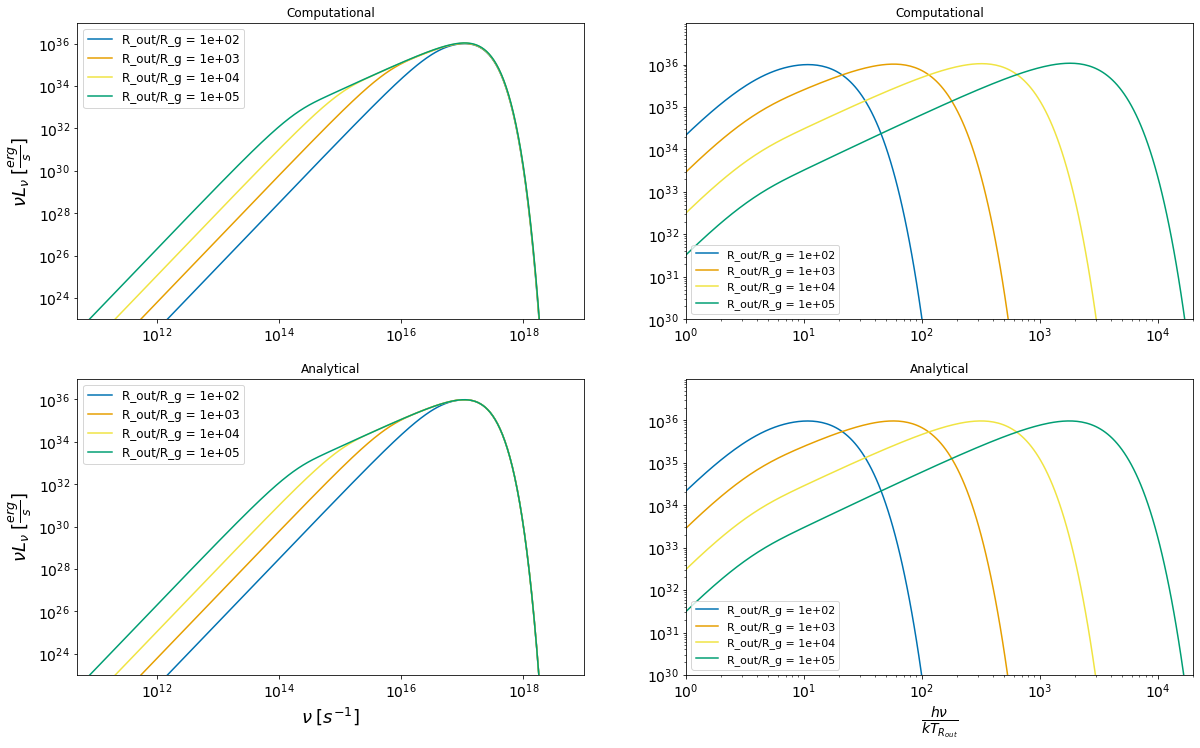

In [17]:
M = 10                                  # black hole mass
x = 0.01                                # fraction of M_dot Edd
alpha = 0.1                             # alpha parameter
incl = 0                                # inclination of the disk in degress
times_Rg_in = 6                         # inner radius : R_in = times_Rg_in * R_g
ntime = 300                             # number of points
t_start = 0.1
opac = 'kramer_electron'                 # opacity  model we use
frequency = np.logspace(0,20,1000)
times_Rg_out_array = [1e2,1e3,1e4,1e5]              # outer radius : R_out = times_Rg_out * R_g

fig, ax = plt.subplots(2,2,figsize=(20,12))
fig.subplots_adjust(wspace=0.2)

for times_Rg_out,color in zip(times_Rg_out_array,Colorblind_custom):
    d = DiskRadialModel(mstar=M*MS,lstar=0*LS,rin=R_g(times_Rg_in,M),rout=R_g(times_Rg_out,M), alpha=alpha, tbg=0.0)
    d.make_disk_from_m_pl(mdisk=10e-10*MS)
    d.compute_nu()

    t_end = 10*(R_g(times_Rg_out,M))**2/((d.nu).mean()) # evolving the disk until 10t_visc            
    time = t_start * (t_end / t_start)**(np.linspace(0., 1., ntime + 1))

    opacity_model(d,opac,ntime,time,M,x)     # calculate the opacity

    r_mid = (d.r[1:]+d.r[:-1])/2             # the mean distance of each ring
    Dr = np.diff(d.r)                        # the width of each ring
    qvisc = d.qvisc[:-1]                     # the viscous dissipation rate for each r, but this r != r_mid thus some error

    flux_anal = np.ones(1000)
    flux_comp = np.ones(1000)

    for i,j in enumerate(frequency):
        flux_anal[i] = np.sum(luminosity(j,M,x,Dr,incl,r_mid,d.qvisc,'analytic',times_Rg_in))   # provided by the analytical solution
        flux_comp[i] = np.sum(luminosity(j,M,x,Dr,incl,r_mid,qvisc,'computational',times_Rg_in)) # computed by the code


    nu_L_nu_anal =frequency*flux_anal
    nu_L_nu_comp =frequency*flux_comp
    nu_L_nu_anal_max = nu_L_nu_anal[np.isfinite(flux_anal,where=True)].max()  # maximum emitted power provided by the analytical solution
    nu_L_nu_comp_max = nu_L_nu_comp[np.isfinite(flux_comp,where=True)].max()  # maximum emitted power provided by the analytical solution

    nu_max_L = frequency[np.where(nu_L_nu_anal==nu_L_nu_anal_max)[0][0]]
    #norm_freq = (frequency*hh)/(kk*T_surf_analytic(M,times_Rg_in,x,R_g(times_Rg_out,M)))
    norm_freq = (frequency*hh)/(kk*T_surf_comp(d.qvisc[-1]))

    ax[0,0].plot(frequency,nu_L_nu_comp,label= 'R_out/R_g = {:.0e}'.format(times_Rg_out), color=color)
    ax[1,0].plot(frequency,nu_L_nu_anal, label='R_out/R_g = {:.0e}'.format(times_Rg_out), color=color)
    ax[0,1].plot(norm_freq,nu_L_nu_comp, label='R_out/R_g = {:.0e}'.format(times_Rg_out), color=color)
    ax[1,1].plot(norm_freq,nu_L_nu_anal, label='R_out/R_g = {:.0e}'.format(times_Rg_out), color=color)
    for i in range(2):
        if i == 0:
            #axis
            ax[0,i].set_ylabel(r'$\nu L_{\nu} \; [\frac{erg}{s}]$', fontsize=18)
            ax[0,i].tick_params(labelsize=14)
            ax[1,i].set_ylabel(r'$\nu L_{\nu} \; [\frac{erg}{s}]$', fontsize=18)
            ax[1,i].tick_params(labelsize=14)
            ax[0,i].set_title('Computational')
            ax[i,1].set_title('Computational')
            
            # scaling axis
            ax[0,i].set_xscale('log')
            ax[i,1].set_xscale('log')
            ax[1,i].set_xscale('log')
            ax[i,0].set_ylim(1e23,10*nu_L_nu_anal_max)      # putting a limit of one order of magnitude > nu*L_nu_max
            ax[i,1].set_ylim(1e30,10*nu_L_nu_anal_max)      # putting a limit of one order of magnitude > nu*L_nu_max
            ax[i,0].set_xlim(5e10,1e19) 
            ax[0,i].legend(prop={'size': 12})
            ax[i,1].legend(prop={'size': 11})
            ax[1,i].legend(prop={'size': 12})
            ax[0,i].set_yscale('log')
            ax[i,1].set_yscale('log')
            ax[1,i].set_yscale('log')
            ax[1,i].set_ylim(1e23,10*nu_L_nu_anal_max)      # putting a limit of one order of magnitude > nu*L_nu_max
            #ax[i,1].set_xlim(1e-4,2e4)
            ax[i,1].set_xlim(1e0,2e4)
        else:
            #axis
            ax[i,0].set_xlabel(r'$\nu \; [s^{-1}]$', fontsize=18)
            ax[0,i].tick_params(labelsize=14)
            ax[1,i].set_xlabel(r'$\frac{h \nu}{kT_{R_{out}}}$', fontsize=20)
            ax[1,i].tick_params(labelsize=14)
            ax[i,0].set_title('Analytical')
            ax[i,1].set_title('Analytical')
            
            #scaling axis
            ax[i,0].set_xlim(5e10,1e19)
            ax[i,1].set_xscale('log')
            ax[i,1].set_yscale('log')
            ax[i,1].set_ylim(1e30,10*nu_L_nu_anal_max)      # putting a limit of one order of magnitude > nu*L_nu_max
            ax[1,i].legend(prop={'size': 11})
            #ax[i,1].set_xlim(1e-4,1e2)
            ax[i,1].set_xlim(1e0,2e4)          
plt.show()


The first subplot corresponds to the SED of the disk for various $R_{out}$. First, as we chose larger outer radius for our model disk the total emitted energy becomes bigger. This is expected, because we simply increase the emitted area, while keeping the accretion rate constant. Hence, we have the same power $L_{acc}$ with a larger now disk and we see that this extra emitted energy comes from the cold outer parts of the disk which correspond to the low-frequency regime in the SED. Second, the effective temperature of the disk seems like is not affected, due to the fact that we the alter the outer and coldest part of the disk, while the inner and hottest part of the disk is the one that dominates the effective temperature. Finally, we see that the multicolor region of the spectrum extents, which is a direct consequence of extending the part of the disk that produces this region in the SED. The second subplot uses the normilized (to the temperature of the outer radius) frequency and simply emphasizes how the multicolor region becomes larger for increasing outer radius.

A note: In terms of the Virial Theorem we may think that the disk should become slightly hotter, because potential energy is now released also from these further out parts of the disk, but $|E_{gr}| \propto \frac{1}{R}$, and thus these increasingly distant parts will provide increasingly smaller energy. Furthermore, as we metioned above the inner and hottest part of the disk is the one that dominates the effective temperature.

**Varying the Accretion Rate**

/tmp/ipykernel_24115/2691846492.py:59: RuntimeWarning: overflow encountered in exp
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_analytic(M,R,x,r)))-1)
/tmp/ipykernel_24115/2691846492.py:61: RuntimeWarning: overflow encountered in exp
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_comp(D)))-1)
/tmp/ipykernel_24115/2691846492.py:59: RuntimeWarning: divide by zero encountered in true_divide
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_analytic(M,R,x,r)))-1)
/tmp/ipykernel_24115/2691846492.py:61: RuntimeWarning: divide by zero encountered in true_divide
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_comp(D)))-1)
/tmp/ipykernel_24115/2691846492.py:59: RuntimeWarning: overflow encountered in exp
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_analytic(M,R,x,r)))-1)
/tmp/ipykernel_24115/2691846492.py:61: RuntimeWarning: overflow encountered in exp
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_comp(D)

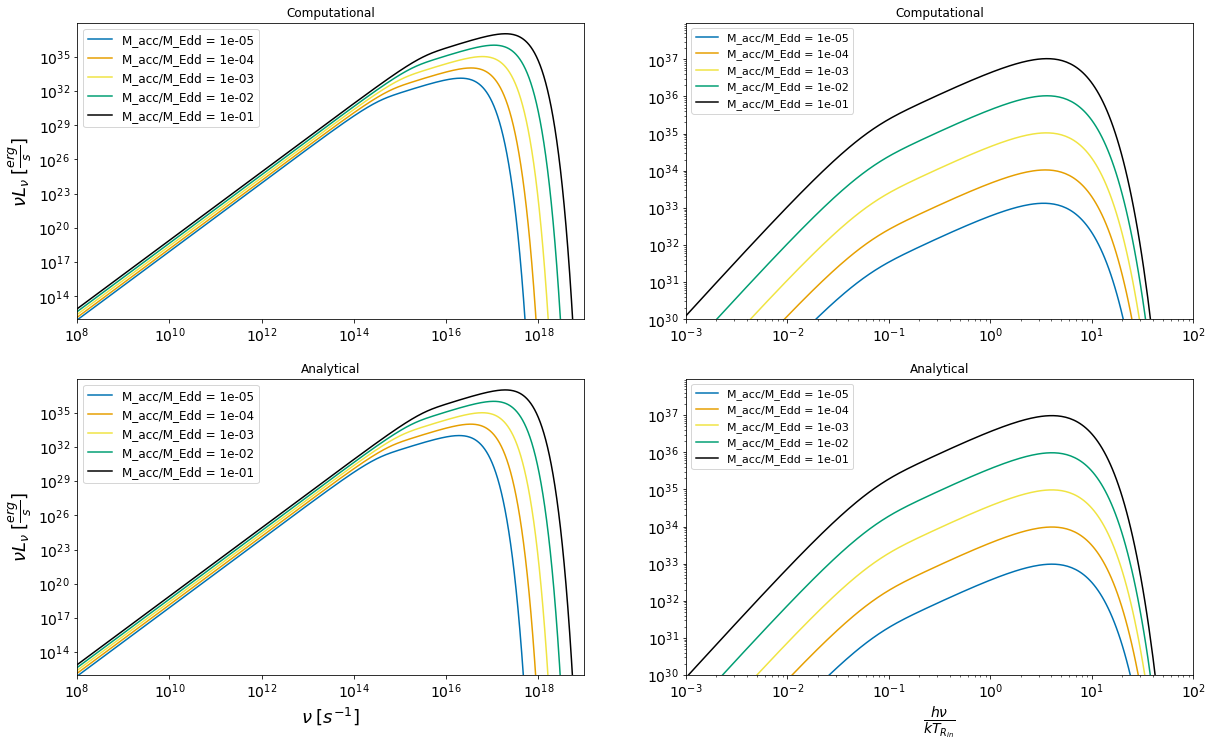

In [18]:
M = 10                                  # black hole mass
alpha = 0.1                             # alpha parameter
incl = 0                                # inclination of the disk in degress
times_Rg_in = 6                         # inner radius : R_in = times_Rg_in * R_g
times_Rg_out = 5000                     # outer radius : R_out = times_Rg_out * R_g
ntime = 300                             # number of points
t_start = 0.1

x_vals = [1e-5,1e-4,1e-3,1e-2,1e-1]                                # fraction of M_dot Edd

frequency = np.logspace(0,20,1000)
d = DiskRadialModel(mstar=M*MS,lstar=0*LS,rin=R_g(times_Rg_in,M),rout=R_g(times_Rg_out,M), alpha=alpha, tbg=0.0)
d.make_disk_from_m_pl(mdisk=10e-10*MS)
d.compute_nu()

t_end = 10*(R_g(times_Rg_out,M))**2/((d.nu).mean()) # evolving the disk until 10t_visc            
time = t_start * (t_end / t_start)**(np.linspace(0., 1., ntime + 1))

opac = 'kramer_electron'                 # opacity  model we use

fig, ax = plt.subplots(2,2,figsize=(20,12))
fig.subplots_adjust(wspace=0.2)
for x,color in zip(x_vals,Colorblind_custom):
    opacity_model(d,opac,ntime,time,M,x)     # calculate the opacity

    r_mid = (d.r[1:]+d.r[:-1])/2             # the mean distance of each ring
    Dr = np.diff(d.r)                        # the width of each ring
    qvisc = d.qvisc[:-1]                     # the viscous dissipation rate for each r, but this r != r_mid thus some error

    flux_anal = np.ones(1000)
    flux_comp = np.ones(1000)

    for i,j in enumerate(frequency):
        flux_anal[i] = np.sum(luminosity(j,M,x,Dr,incl,r_mid,d.qvisc,'analytic',times_Rg_in))   # provided by the analytical solution
        flux_comp[i] = np.sum(luminosity(j,M,x,Dr,incl,r_mid,qvisc,'computational',times_Rg_in)) # computed by the code


    nu_L_nu_anal =frequency*flux_anal
    nu_L_nu_comp =frequency*flux_comp
    nu_L_nu_anal_max = nu_L_nu_anal[np.isfinite(flux_anal,where=True)].max()  # maximum emitted power provided by the analytical solution
    nu_L_nu_comp_max = nu_L_nu_comp[np.isfinite(flux_comp,where=True)].max()  # maximum emitted power provided by the analytical solution

    nu_max_L = frequency[np.where(nu_L_nu_anal==nu_L_nu_anal_max)[0][0]]
    norm_freq_anal = (frequency*hh)/(kk*T_surf_analytic(M,times_Rg_in,x,R_g(times_Rg_in+1e-1,M))) # small addition become the analytic solution breaks at R=R_in
    norm_freq_comp = (frequency*hh)/(kk*T_surf_comp(d.qvisc[0]))
    
    ax[0,0].plot(frequency,nu_L_nu_comp,label='M_acc/M_Edd = {:.0e}'.format(x), color=color)
    ax[1,0].plot(frequency,nu_L_nu_anal, label='M_acc/M_Edd = {:.0e}'.format(x), color=color)
    ax[0,1].plot(norm_freq_comp,nu_L_nu_comp, label='M_acc/M_Edd = {:.0e}'.format(x), color=color)
    ax[1,1].plot(norm_freq_anal,nu_L_nu_anal, label='M_acc/M_Edd = {:.0e}'.format(x), color=color)
    for i in range(2):
        if i == 0:
            #axis
            ax[0,i].set_ylabel(r'$\nu L_{\nu} \; [\frac{erg}{s}]$', fontsize=18)
            ax[0,i].tick_params(labelsize=14)
            ax[1,i].set_ylabel(r'$\nu L_{\nu} \; [\frac{erg}{s}]$', fontsize=18)
            ax[1,i].tick_params(labelsize=14)
            ax[0,i].set_title('Computational')
            ax[i,1].set_title('Computational')
            
            # scaling axis
            ax[0,i].set_xscale('log')
            ax[i,1].set_xscale('log')
            ax[1,i].set_xscale('log')
            ax[i,0].set_ylim(1e12,10*nu_L_nu_anal_max)      # putting a limit of one order of magnitude > nu*L_nu_max
            ax[i,1].set_ylim(1e30,10*nu_L_nu_anal_max)      # putting a limit of one order of magnitude > nu*L_nu_max
            ax[i,0].set_xlim(1e8,1e19)
            ax[0,i].legend(prop={'size': 12})
            ax[i,1].legend(prop={'size': 11})
            ax[1,i].legend(prop={'size': 12})
            ax[0,i].set_yscale('log')
            ax[i,1].set_yscale('log')
            ax[1,i].set_yscale('log')
            ax[1,i].set_ylim(1e12,10*nu_L_nu_anal_max)      # putting a limit of one order of magnitude > nu*L_nu_max
            ax[i,1].set_xlim(1e-3,1e2)
        else:
            #axis
            ax[i,0].set_xlabel(r'$\nu \; [s^{-1}]$', fontsize=18)
            ax[0,i].tick_params(labelsize=14)
            ax[1,i].set_xlabel(r'$\frac{h \nu}{kT_{R_{in}}}$', fontsize=20)
            ax[1,i].tick_params(labelsize=14)
            ax[i,0].set_title('Analytical')
            ax[i,1].set_title('Analytical')
            
            #scaling axis
            ax[i,0].set_xlim(1e8,1e19)
            ax[i,1].set_xscale('log')
            ax[i,1].set_yscale('log')
            ax[i,1].set_ylim(1e30,10*nu_L_nu_anal_max)      # putting a limit of one order of magnitude > nu*L_nu_max
            ax[1,i].legend(prop={'size': 11})
            ax[i,1].set_xlim(1e-3,1e2)          
plt.show()


The first subplot corresponds to the SED of the disk for various $\dot{m}$. First, as we chose higher accretion rates we see that  the disk becomes hotter and the total emitted energy becomes bigger. This behavior is logical because the accreted gas 'feeds' the disk heating. We can think that the viscous dessipation rate is directly proportional to the surface density (Eq.(8)), which is proportional to the $\dot{m}$. The viscous dessipation rate determines the temperature at the mid plane, (Eq.(9), of the disk and for a given opacity the temperature at the surface, Eq.(10). Hence, for increasing accretion rate the disk becomes hotter ($T_{mid}$ rises), thus the peak moves to higher frequencies and the increasing surface temperature results to the increase of the total emitted energy. It is also intersting to note that the additional emitted energy corresponds to high frequency photons because the inner part becomes increasingly hotter. The second subplot uses the normilized (to the temperature of the inner radius) frequency and simply emphasizes how the total emitted energy becomes larger for increasing the accretion rate.

**Varying the Black Hole Mass**

/tmp/ipykernel_24115/2691846492.py:59: RuntimeWarning: divide by zero encountered in true_divide
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_analytic(M,R,x,r)))-1)
/tmp/ipykernel_24115/2691846492.py:61: RuntimeWarning: divide by zero encountered in true_divide
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_comp(D)))-1)
/tmp/ipykernel_24115/2691846492.py:59: RuntimeWarning: overflow encountered in exp
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_analytic(M,R,x,r)))-1)
/tmp/ipykernel_24115/2691846492.py:61: RuntimeWarning: overflow encountered in exp
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_comp(D)))-1)
/tmp/ipykernel_24115/2691846492.py:59: RuntimeWarning: divide by zero encountered in true_divide
  planck_func = (2*hh*nu**3/cc**2)/(np.exp((hh*nu)/(kk*T_surf_analytic(M,R,x,r)))-1)
/tmp/ipykernel_24115/2691846492.py:61: RuntimeWarning: divide by zero encountered in true_divide
  planck_func = (2*hh*nu**3/cc**2)/(np.ex

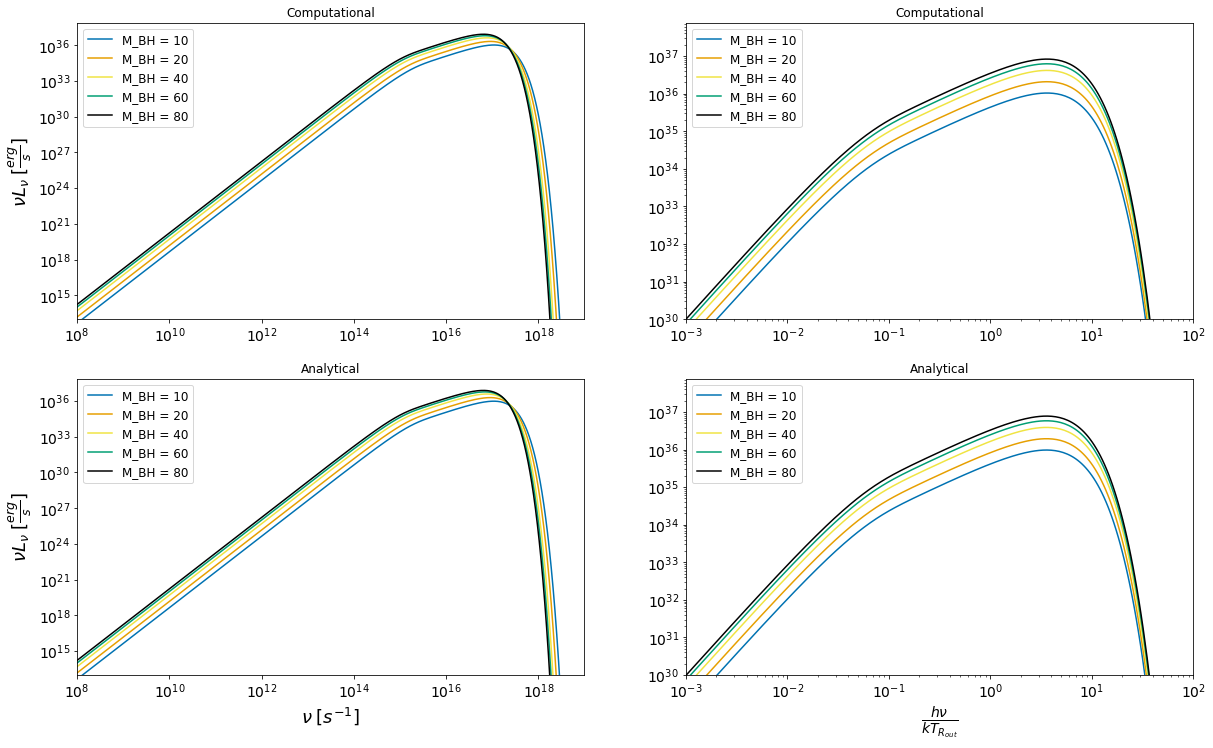

In [19]:
x = 0.01                                # fraction of M_dot Edd
alpha = 0.1                             # alpha parameter
incl = 0                                # inclination of the disk in degress
times_Rg_in = 6                         # inner radius : R_in = times_Rg_in * R_g
times_Rg_out = 5000                     # outer radius : R_out = times_Rg_out * R_g
ntime = 300                             # number of points
t_start = 0.1
opac = 'kramer_electron'                 # opacity  model we use
frequency = np.logspace(0,20,1000)
M_array = [1e1,2e1,4e1,6e1,8e1]              # black hole mass

fig, ax = plt.subplots(2,2,figsize=(20,12))
fig.subplots_adjust(wspace=0.2)

for M,color in zip(M_array,Colorblind_custom):
    d = DiskRadialModel(mstar=M*MS,lstar=0*LS,rin=R_g(times_Rg_in,M),rout=R_g(times_Rg_out,M), alpha=alpha, tbg=0.0)
    d.make_disk_from_m_pl(mdisk=10e-10*MS)
    d.compute_nu()

    t_end = 10*(R_g(times_Rg_out,M))**2/((d.nu).mean()) # evolving the disk until 10t_visc            
    time = t_start * (t_end / t_start)**(np.linspace(0., 1., ntime + 1))

    opacity_model(d,opac,ntime,time,M,x)     # calculate the opacity

    r_mid = (d.r[1:]+d.r[:-1])/2             # the mean distance of each ring
    Dr = np.diff(d.r)                        # the width of each ring
    qvisc = d.qvisc[:-1]                     # the viscous dissipation rate for each r, but this r != r_mid thus some error

    flux_anal = np.ones(1000)
    flux_comp = np.ones(1000)

    for i,j in enumerate(frequency):
        flux_anal[i] = np.sum(luminosity(j,M,x,Dr,incl,r_mid,d.qvisc,'analytic',times_Rg_in))   # provided by the analytical solution
        flux_comp[i] = np.sum(luminosity(j,M,x,Dr,incl,r_mid,qvisc,'computational',times_Rg_in)) # computed by the code


    nu_L_nu_anal =frequency*flux_anal
    nu_L_nu_comp =frequency*flux_comp
    nu_L_nu_anal_max = nu_L_nu_anal[np.isfinite(flux_anal,where=True)].max()  # maximum emitted power provided by the analytical solution
    nu_L_nu_comp_max = nu_L_nu_comp[np.isfinite(flux_comp,where=True)].max()  # maximum emitted power provided by the analytical solution

    nu_max_L = frequency[np.where(nu_L_nu_anal==nu_L_nu_anal_max)[0][0]]
    #norm_freq = (frequency*hh)/(kk*T_surf_analytic(M,times_Rg_in,x,R_g(times_Rg_out,M)))
    norm_freq = (frequency*hh)/(kk*T_surf_comp(d.qvisc[0]))

    ax[0,0].plot(frequency,nu_L_nu_comp, label= 'M_BH = {:.0f}'.format(M), color=color)
    ax[1,0].plot(frequency,nu_L_nu_anal, label= 'M_BH = {:.0f}'.format(M), color=color)
    ax[0,1].plot(norm_freq,nu_L_nu_comp, label= 'M_BH = {:.0f}'.format(M), color=color)
    ax[1,1].plot(norm_freq,nu_L_nu_anal, label= 'M_BH = {:.0f}'.format(M), color=color)
    for i in range(2):
        if i == 0:
            #axis
            ax[0,i].set_ylabel(r'$\nu L_{\nu} \; [\frac{erg}{s}]$', fontsize=18)
            ax[0,i].tick_params(labelsize=14)
            ax[1,i].set_ylabel(r'$\nu L_{\nu} \; [\frac{erg}{s}]$', fontsize=18)
            ax[1,i].tick_params(labelsize=14)
            ax[0,i].set_title('Computational')
            ax[i,1].set_title('Computational')
            
            # scaling axis
            ax[0,i].set_xscale('log')
            ax[i,1].set_xscale('log')
            ax[1,i].set_xscale('log')
            ax[i,0].set_ylim(1e13,10*nu_L_nu_anal_max)      # putting a limit of one order of magnitude > nu*L_nu_max
            ax[i,1].set_ylim(1e30,10*nu_L_nu_anal_max)      # putting a limit of one order of magnitude > nu*L_nu_max
            ax[i,0].set_xlim(1e8,1e19)
            ax[0,i].legend(prop={'size': 12})
            ax[i,1].legend(prop={'size': 12})
            ax[1,0].legend(prop={'size': 12})
            ax[0,i].set_yscale('log')
            ax[i,1].set_yscale('log')
            ax[1,i].set_yscale('log')
            ax[1,i].set_ylim(1e13,10*nu_L_nu_anal_max)      # putting a limit of one order of magnitude > nu*L_nu_max
            ax[i,1].set_xlim(1e-3,1e2)
        else:
            #axis
            ax[i,0].set_xlabel(r'$\nu \; [s^{-1}]$', fontsize=18)
            ax[0,i].tick_params(labelsize=14)
            ax[1,i].set_xlabel(r'$\frac{h \nu}{kT_{R_{out}}}$', fontsize=20)
            ax[1,i].tick_params(labelsize=14)
            ax[i,0].set_title('Analytical')
            ax[i,1].set_title('Analytical')
            
            #scaling axis
            ax[i,0].set_xlim(1e8,1e19)
            ax[i,1].set_xscale('log')
            ax[i,1].set_yscale('log')
            ax[i,1].set_ylim(1e30,10*nu_L_nu_anal_max)      # putting a limit of one order of magnitude > nu*L_nu_max
            ax[1,i].legend(prop={'size': 12})
            ax[i,1].set_xlim(1e-3,1e2)          
plt.show()

The first subplot corresponds to the SED of the disk for various $M$. First, as we chose higher black hole masses we see that the disk becomes slightly colder, while the total emitted energy becomes bigger. At this point, we need to consider that most parameters scale with the black hole mass. First, the disk becomes larger, because the inner, $R_{in}$ and the outer, $R_{out}$, radius of the disk scale with $M$ through $R_g$, Eq(4) and the accretion rate, $\dot{m}$, also scales with $M$ through $R_{in}$, Eq.(3). Hence, it is really straight forward why we end up with a larger total emitted energy. Furthermore,  there may be some degeneracies between these parameters, simply because all of them are proportional with the mass, $M$. On the other hand, to understand why the disk becomes slightly colder we can do a simple dimensional analysis, starting with Eq.(8):


$$\sigma_{B} T_s^4 = \frac{9}{4} \Sigma(r) \nu(r) \Omega_{K}^{2}(r)$$

and we focus only the parameters that scale with the $M$

$$ T_s^4 \propto \dot{m} M R^{-3}$$

$$ T_s \propto M^{1/4} M^{1/4} M^{-3/4}$$

$$T_{s} \propto M^{-1/4}$$

The above dimensional analysis indicates that the surface temperature will indeed drop for increasing mass. This allows to spaculated over further implications. For a constant optical depth Eq.(10) implies that the height scale should also decrease indicating that for increasing black hole mass the disk becomes thinner (for ideal gas the pressure is $\propto$ to the midplane temperature). The second subplot uses the normalized (to the temperature of the inner radius) frequency and simply emphasizes how the total emitted energy becomes larger for increasing the accretion rate.